### A fine grained PGA (parallel genetic algorithm)

In [1]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display 
import itertools
from IPython.display import display
import random
import operator
from random import choices, randint, randrange, random, sample, seed, uniform, choice
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial
sns.set()
import random

In [2]:
#np.random.seed(0)
#random.seed(0)

In [3]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [4]:
class MarketConfig: 
    #class attributes
    t0 = 2016 #The starting year for evaluation of the pay-offs
    T = 35  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2016, 2051)
    distance = np.array([11810]) #nautical miles #Notteboom (2006)  
    port_time =  np.array([264])  #hours ==> 11 days in a year  #Notteboom (2006)
    demand_16_20 = np.array([1303780  for j in range(5)]) #in TEU #placehplder to be calibrated with the chosen route 
    annual_working_time = np.array([6480])  #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = np.array([1800])  ## in US$/TEU 
    SFOC_main = np.array([206])  #g/kWh, specific daily main engine fuel oil consumption rate
    SFOC_aux = np.array([221]) # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = np.array([0.8]) # % 
    eng_load_aux = np.array([0.5])  # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, pollution_decay_parameter, pollution_damage_parameter, demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.pollution_decay_parameter = pollution_decay_parameter
        self.pollution_damage_parameter = pollution_damage_parameter
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        self.market_capacity = 0 
         
    
    def get_market_capacity (self, firm_instance):
        self.market_capacity += np.multiply(firm_instance.max_number_of_vessel, firm_instance.capacity) 
        return self.market_capacity 
    
    def get_freight_rate_ratio(self):
        self.beta = np.true_divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('./data/real_growth_rate.csv') #import IMF data
        #-------> 2.Construct GDP projection path 2016-2050 based on projection growth data 
        gdp_growth= G_df.values[:,1:] 
        g =1 +(gdp_growth/100)  
        self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        for foo in range (1,MarketConfig.T):
            self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([1.00 for j in range(MarketConfig.T)])
        for moo in range (1,MarketConfig.T):
            sub_g = g[:,0:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        self.market_demand = np.multiply(loo, MarketConfig.demand_16_20[0])
        #print(Y) # size = 1 dimesion array with size T=35 years
        self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_16_20[0] )
        return self.market_demand, self.gdp, self.market_psy

In [5]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, max_number_of_vessel, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        #self.bau_emission = bau_emission
         
   
    # Firm methods 
    def get_market_share(self , market_instance):
        '''return market share of the firm accoding to it s capacity'''
        self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        self.market_share= np.true_divide(self.transport_capacity, market_instance.market_capacity)
        return self.market_share
        
    def get_firm_param(self, market_instance):
        self.psy = np.multiply (self.market_share , market_instance.market_psy)
        return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        return self.firm_demand 
    
    def update_vessel_speed(self, operational_speed):
        self.operational_speed = operational_speed
        return self.operational_speed 
    
    def get_min_number_of_vessel(self, market_instance):
        self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed) #returns a vector 
        self.voyage_time = self.time_at_sea + market_instance.port_time #returns a vector 
        self.number_of_trips_to_meet_demand = np.true_divide(self.firm_demand, self.capacity) #returns a vector
        self.max_trips_per_vessel = np.true_divide(market_instance.annual_working_time, self.voyage_time) #returns a vector
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel) #returns a vector
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand) #returns a vector
        return self.number_of_vessel
            
    def get_ship_energy_efficiency(self, market_instance):
        self.main_fuel_parameter =np.multiply(np.multiply(np.multiply(market_instance.SFOC_main,market_instance.eng_load_main),self.main_engine_power), 10**(-6))
        #self.main_fuel_parameter = market_instance.SFOC_main * market_instance.eng_load_main * self.main_engine_power * 10**(-6)
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )      
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance):
        self.main_fuel_con= np.multiply(np.multiply(np.multiply(market_instance.distance, self.ship_energy), np.power(self.operational_speed, 2)) , self.number_of_trips_to_meet_demand)
        self.main_fuel_cons = market_instance.distance * self.ship_energy * (self.operational_speed**2) *self.number_of_trips_to_meet_demand
        return self.main_fuel_cons #returns a vector
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = np.multiply(np.multiply(np.multiply( market_instance.SFOC_aux, market_instance.eng_load_aux), self.aux_engine_power),  10**(-6))
        #self.aux_fuel_parameter = market_instance.SFOC_aux * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  np.true_divide((self.aux_fuel_parameter * self.number_of_trips_to_meet_demand * market_instance.distance), self.operational_speed)        
        return self.aux_fuel_cons #returns a vector   
    
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost =np.multiply(self.aux_fuel_cons, market_instance.fuel_data['MGO']['price'])  
        self.main_fuel_cost = np.multiply(self.main_fuel_cons, market_instance.fuel_data[self.fuel_type]['price'])   
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost 
        return self.fuel_cost #returns a vector
    
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self_carbon_aux_emissions = np.multiply(self.carbon_aux_emision_factor, self.aux_fuel_cons )  
        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self_carbon_main_emissions =np.multiply(self.carbon_main_emision_factor, self.main_fuel_cons)  
        self_carbon_emissions = self_carbon_main_emissions + self_carbon_aux_emissions 
        return self_carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self_sulfur_aux_emissions = np.multiply(self.sulfur_aux_emision_factor, self.aux_fuel_cons)  
        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self_sulfur_main_emissions = np.multiply(self.sulfur_main_emision_factor, self.main_fuel_cons)  
        self_sulfur_emissions = self_sulfur_main_emissions + self_sulfur_aux_emissions 
        return self_sulfur_emissions      
    
            
    def get_total_cost(self):
        self.operating_cost = np.multiply(self.fix_cost, self.number_of_vessel)  #Fixed Cost
        self.total_cost = self.operating_cost + self.fuel_cost
        return self.total_cost #returns a vector    
    
    def update_total_cost(self, total_cost_with_policy):
        self.total_cost = total_cost_with_policy
        return self.total_cost 
                 
    def get_revenue(self,market_instance):
        self.revenue = np.multiply(self.firm_demand, market_instance.freight_rate)
        return self.revenue #returns a vector
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost
        return self.period_profit #returns a vector
    
    def get_discounted_period_profit(self,market_instance, planning_horizon):
        self.period_index_vector = np.arange(1,planning_horizon + 1)
        self.discount_multiplier = np.power( 1+ market_instance.discount_rate, - self.period_index_vector)
        self.discounted_period_profit = np.multiply( self.discount_multiplie, self.period_profit) 
        return self.discounted_period_profit #returns a vector



In [6]:
#====> Iinitialisation of chromo and population objects 
Chromo = List[float] 
Population = List[Chromo]  

#====> Iinitialisation of function objects
PopulateFunc = Callable[[], Population]
FitnessFunc = Callable[[Chromo], Tuple[float, int, float, float]] #int to refelct max # of vessel
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one

In [7]:
#======>
def generate_chromo(lower_bound:float, upper_bound:float, planning_horizon:int ,fitness_func: FitnessFunc) :
    while True:
        chromo = np.random.uniform(lower_bound, upper_bound, planning_horizon )   
        if fitness_func(chromo)[0] != 0:
            break
    return chromo  
def generate_population(fitness_func: FitnessFunc, 
                        size: int, chromo_lower_bound: float, 
                        chromo_upper_bound: float, planning_horizon:int ): 
    return np.array([generate_chromo(chromo_lower_bound, chromo_upper_bound, planning_horizon, fitness_func) for _ in range(size)])


In [8]:
#======> Sample of the population: Assume 5 periods(chromo length ) and a population size of 10
data =  np.array([(np.random.uniform(10, 12, 2)) for _ in range(16)])
data

array([[10.02733905, 10.30828729],
       [10.95233229, 11.4304653 ],
       [10.2605828 , 11.91957063],
       [11.5573592 , 11.86083643],
       [10.97351253, 10.54363103],
       [11.35650611, 11.51352875],
       [11.99289141, 10.24770857],
       [10.9682427 , 11.28989747],
       [11.83295401, 11.56082154],
       [10.01660715, 10.67203462],
       [11.20258701, 11.15884496],
       [11.81119978, 10.90737755],
       [10.434337  , 10.49046728],
       [10.43582625, 10.82993221],
       [11.16172744, 10.21555924],
       [11.06490624, 10.07445328]])

In [9]:
data = data.reshape(4,4,2)#(sqrt(pop size) , sqrt(pop size), #of periods )
data

array([[[10.02733905, 10.30828729],
        [10.95233229, 11.4304653 ],
        [10.2605828 , 11.91957063],
        [11.5573592 , 11.86083643]],

       [[10.97351253, 10.54363103],
        [11.35650611, 11.51352875],
        [11.99289141, 10.24770857],
        [10.9682427 , 11.28989747]],

       [[11.83295401, 11.56082154],
        [10.01660715, 10.67203462],
        [11.20258701, 11.15884496],
        [11.81119978, 10.90737755]],

       [[10.434337  , 10.49046728],
        [10.43582625, 10.82993221],
        [11.16172744, 10.21555924],
        [11.06490624, 10.07445328]]])

In [10]:
data #returns first row

array([[[10.02733905, 10.30828729],
        [10.95233229, 11.4304653 ],
        [10.2605828 , 11.91957063],
        [11.5573592 , 11.86083643]],

       [[10.97351253, 10.54363103],
        [11.35650611, 11.51352875],
        [11.99289141, 10.24770857],
        [10.9682427 , 11.28989747]],

       [[11.83295401, 11.56082154],
        [10.01660715, 10.67203462],
        [11.20258701, 11.15884496],
        [11.81119978, 10.90737755]],

       [[10.434337  , 10.49046728],
        [10.43582625, 10.82993221],
        [11.16172744, 10.21555924],
        [11.06490624, 10.07445328]]])

In [ ]:
Firm._registry

In [ ]:
#=====>
def selection_pair (population: Population, weights: list):
    return  np.random.choice(np.hstack( population),
                            size = 2, 
                            replace=False,
                            p= weights) 
#=======>
def BLX_alpha_crossover (a: Chromo, b: Chromo, chromo_lower_bound: float, chromo_upper_bound:float) :
    lower = min(a,b) -  0.5 * (max(a,b) - min (a,b))
    upper = max(a,b) +  0.5 * (max(a,b) - min (a,b))   
    lower = chromo_lower_bound if lower < chromo_lower_bound else lower
    upper = chromo_upper_bound if upper > chromo_upper_bound else upper
    return np.random.uniform (lower, upper, 2) 

#=====>
def mutation(chromo: Chromo, chromo_lower_bound: float, chromo_upper_bound: float
             , variance: float, probability: float = 0.5 ) : 
        chromo = np.random.normal(chromo, variance, 1) if random.random() > probability else chromo
        chromo = chromo_lower_bound if chromo <chromo_lower_bound else chromo
        chromo =chromo_upper_bound if chromo > chromo_upper_bound else chromo
        return chromo

In [ ]:
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = 0
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = 1
    return result



def chromo_deviation_chech(max_fitness, number_of_similarity):
    pass

In [57]:
randrange(10+1)

8

In [58]:
Firm._registry

In [59]:
population = {} 
population["firm" + str(evolving_species.index)] = data 

population

NameError: name 'evolving_species' is not defined

In [60]:
population["firm" + str(evolving_species.index)][2,2]

NameError: name 'evolving_species' is not defined

In [61]:
population["firm" + str(evolving_species.index)][2-1:2+2, 2-1:2+2 ]

NameError: name 'evolving_species' is not defined

In [62]:
population["firm" + str(evolving_species.index)].take(range(2-1,2+2),mode='wrap', axis=0).take(range(2-1,2+2),mode='wrap',axis=1)


NameError: name 'evolving_species' is not defined

In [63]:
np.choose([2-1:2+2, 2-1:2+2 ], population["firm" + str(evolving_species.index)], mode='wrap')

SyntaxError: invalid syntax (<ipython-input-63-a147c6a8845c>, line 1)

In [64]:
"population_"+"firm_" + str(evolving_species.index) 

NameError: name 'evolving_species' is not defined

In [65]:
evolving_species = random.choice(Firm._registry)
evolving_species.index       

2

In [66]:
symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species]
symbiotic_species[1]

In [67]:
population["firm1"] = data 
population["firm2"] = data 


In [68]:
population["firm3"]

KeyError: 'firm3'

In [69]:
population["firm1"]

array([[[10.02733905, 10.30828729],
        [10.95233229, 11.4304653 ],
        [10.2605828 , 11.91957063],
        [11.5573592 , 11.86083643]],

       [[10.97351253, 10.54363103],
        [11.35650611, 11.51352875],
        [11.99289141, 10.24770857],
        [10.9682427 , 11.28989747]],

       [[11.83295401, 11.56082154],
        [10.01660715, 10.67203462],
        [11.20258701, 11.15884496],
        [11.81119978, 10.90737755]],

       [[10.434337  , 10.49046728],
        [10.43582625, 10.82993221],
        [11.16172744, 10.21555924],
        [11.06490624, 10.07445328]]])

In [70]:
symbiotic_population[] = [population["firm" + str(_.index)]  for _ in Firm._registry if _ != evolving_species ]
symbiotic_population["firm1"]

SyntaxError: invalid syntax (<ipython-input-70-5b2735f9d837>, line 1)

In [71]:
symbiotic_population = {}
for _ in (symbiotic_species):
    symbiotic_population["firm" + str(_.index)] = population["firm" + str(_.index)]  
   

KeyError: 'firm3'

In [72]:
symbiotic_population['firm1']['']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [73]:
symbiotic_neighberhood ={}
for _ in (symbiotic_species):
    symbiotic_neighberhood["firm" + str(_.index)] = symbiotic_population["firm" + str(_.index)].take(range(2 - 1,
                                                       2 + 2 ),
                                                 mode='wrap', 
                                                 axis = 0).take(range(2 - 1, 
                                                                      2 + 2),
                                                                mode='wrap',
                                                                axis=1)

KeyError: 'firm3'

In [74]:
symbiotic_neighberhood["firm1" ]#[0][1]


array([[[11.35650611, 11.51352875],
        [11.99289141, 10.24770857],
        [10.9682427 , 11.28989747]],

       [[10.01660715, 10.67203462],
        [11.20258701, 11.15884496],
        [11.81119978, 10.90737755]],

       [[10.43582625, 10.82993221],
        [11.16172744, 10.21555924],
        [11.06490624, 10.07445328]]])

In [75]:
#evolving_population
candidate_partner ={}

In [76]:
candidate_partner["firm1"] = np.reshape(symbiotic_neighberhood["firm1" ], (9, 2)) #(l*m, n)

In [77]:
candidate_partner["firm2"] = np.reshape(symbiotic_neighberhood["firm2" ], (9, 2)) #(l*m, n)

KeyError: 'firm2'

In [78]:
candidate_partner['firm1'][0]

array([11.35650611, 11.51352875])

In [905]:
carbon_emissions={}
carbon_emissions["firm1"]={}
carbon_emissions["firm2"]={}
carbon_emissions["firm3"]={}
carbon_emissions["firm1"]["chromo0"]= [3,10] 
carbon_emissions["firm1"]["chromo1"]= [4,15]
carbon_emissions["firm2"]["chromo0"]= [5,16] 
carbon_emissions["firm2"]["chromo1"]= [6,16] 
carbon_emissions["firm3"]["chromo0"]= [7,17]
carbon_emissions["firm3"]["chromo1"]= [8,18]
carbon_emissions

In [906]:
carbon_emissions["firm1"]={}
carbon_emissions["firm2"]={}
carbon_emissions["firm3"]={}

In [907]:
carbon_emissions["firm1"]["chromo0"]= [3,10] 
carbon_emissions["firm1"]["chromo1"]= [4,15]
carbon_emissions["firm2"]["chromo0"]= [5,16] 
carbon_emissions["firm2"]["chromo1"]= [6,16] 
carbon_emissions["firm3"]["chromo0"]= [7,17]
carbon_emissions["firm3"]["chromo1"]= [8,18]
carbon_emissions

{'firm1': {'chromo0': [3, 10], 'chromo1': [4, 15]},
 'firm2': {'chromo0': [5, 16], 'chromo1': [6, 16]},
 'firm3': {'chromo0': [7, 17], 'chromo1': [8, 18]}}

In [1173]:
carbon_emissions

{'firm1': {'chromo0': [3, 10, 20], 'chromo1': [4, 15, 30]},
 'firm2': {'chromo0': [5, 16, 40], 'chromo1': [6, 16, 50]},
 'firm3': {'chromo0': [7, 17, 60], 'chromo1': [8, 18, 70]}}

In [859]:
q = [list(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]
q[0]

[('firm1', 'chromo0'), ('firm2', 'chromo0'), ('firm3', 'chromo0')]

In [860]:
q[0]#['firm1']
bobo = {}

In [861]:
combo = [dict(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]
for _ in range(len(mycombo)):
    for firm in mycombo[_].keys():
        mycombo[_].update({str(firm): {str(mycombo[_][str(firm)]): 
                         carbon_emissions[str(firm)][str(bobo[0][str(firm)])]}})



KeyError: 0

In [892]:
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]},
  'em': {}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]},
  'em': {}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]},
  'em': {}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]},
  'em': {}}]

In [936]:
industry_carbon_emission_combo={}
industry_carbon_emission_combo = [dict(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]
for _ in range(len(industry_carbon_emission_combo)):
    for firm in industry_carbon_emission_combo[_].keys():
        industry_carbon_emission_combo[_].update({str(firm): {str(industry_carbon_emission_combo[_][str(firm)]): 
                                 carbon_emissions[str(firm)][str(industry_carbon_emission_combo[_][str(firm)])]}})
industry_carbon_emission_combo

for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["industry_carbon_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))



In [924]:
industry_carbon_emission_combo = [dict(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]
for _ in range(len(industry_carbon_emission_combo)):
    for firm in industry_carbon_emission_combo[_].keys():
        industry_carbon_emission_combo[_].update({str(firm): {str(industry_carbon_emission_combo[_][str(firm)]): 
                                 carbon_emissions[str(firm)][str(industry_carbon_emission_combo[_][str(firm)])]}})
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]}}]

In [925]:
firms = list (industry_carbon_emission_combo[0].keys())
firms

['firm1', 'firm2', 'firm3']

In [926]:
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["industry_carbon_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))


[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]


In [929]:
industry_carbon_emission_combo[0]['industry_carbon_emission']

array([15, 43])

In [833]:
industry_carbon_emission_combo[0]['firm1'].get('chromo0')

[3, 10]

In [758]:
industry_carbon_emission_combo[0]['firm1'].items()

dict_items([('chromo0', [3, 10])])

In [ ]:
industry_carbon_emission_combo[0]['firm1'].get('chromo0')

In [768]:
firm = 'firm1'



for bla in ((industry_carbon_emission_combo[0]["firm1"].keys())):
    print(bla)

AttributeError: 'str' object has no attribute 'keys'

In [704]:
list(industry_carbon_emission_combo[0]['firm1'].values())


[[3, 10]]

In [710]:
gen = (list(industry_carbon_emission_combo[0][str(firm)].values()) for firm in industry_carbon_emission_combo[_].keys())

np.sum(np.fromiter(gen))

TypeError: fromiter() missing required argument 'dtype' (pos 2)

In [660]:
industry_carbon_emission_combo[0].values()

dict_values([{'chromo0': [3, 10]}, {'chromo0': [5, 16]}, {'chromo0': [7, 17]}])

In [917]:
x=np.array(industry_carbon_emission_combo[0].get('firm1').get("chromo0"))
y=np.array(industry_carbon_emission_combo[0].get('firm2').get("chromo0"))
z=np.array(industry_carbon_emission_combo[0].get('firm3').get("chromo0"))

# np.sum([np.array(industry_carbon_emission_combo[0].get('firm1').get("chromo0")),
#         np.array(industry_carbon_emission_combo[0].get('firm2').get("chromo0")),
#         np.array(industry_carbon_emission_combo[0].get('firm3').get("chromo0"))],
#        axis=0)
x+y+z


array([15, 43])

In [918]:
x

array([ 3, 10])

In [790]:
keys, values = zip(*industry_carbon_emission_combo[0]['firm1'].items())
keys[0]
values[0]

[3, 10]

In [791]:
industry_carbon_emission_combo[0]['firm1'].get('chromo0')

[3, 10]

In [ ]:
np.sum([np.array(industry_carbon_emission_combo[0].get('firm1').get("chromo0")),
        np.array(industry_carbon_emission_combo[0].get('firm2').get("chromo0")),
        np.array(industry_carbon_emission_combo[0].get('firm3').get("chromo0"))],
       axis=0)

In [683]:
industry_carbon_emission_combo[0]["firm1"].values()

dict_values([[3, 10]])

In [743]:
list(industry_carbon_emission_combo[3]['firm2'].keys())

['chromo1']

In [828]:
industry_carbon_emission_combo = {}
industry_carbon_emission_combo


{}

In [870]:
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]}}]

In [874]:
for _ in range(len(industry_carbon_emission_combo)):
    print(_)
    industry_carbon_emission_combo[_]["em"]= {}

0
1
2
3
4
5
6
7


In [875]:
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]},
  'em': {}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]},
  'em': {}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]},
  'em': {}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]},
  'em': {}},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]},
  'em': {}}]

In [886]:
industry_carbon_emission_combo[1][str(firm)].items()

dict_items([])

In [890]:
industry_carbon_emission_combo[1].items()

dict_items([('firm1', {'chromo0': [3, 10]}), ('firm2', {'chromo0': [5, 16]}), ('firm3', {'chromo1': [8, 18]}), ('em', {})])

In [891]:
print(sum(industry_carbon_emission_combo[0].values()))


dict_values([{'chromo0': [3, 10]}, {'chromo0': [5, 16]}, {'chromo0': [7, 17]}, {}])


<ipython-input-891-1552490487a7>:1: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(industry_carbon_emission_combo[0].values()))


In [899]:
firms = industry_carbon_emission_combo[0].keys()
type(firms)
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["industry_carbon_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))
        print(x)

dict_keys

In [ ]:
industry_carbon_emission_combo[] = 

In [910]:
firms = list (industry_carbon_emission_combo[0].keys())
firms

['firm1', 'firm2', 'firm3']

In [922]:
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["industry_carbon_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))
        print(x)
        #print(chromos[0], firm_carbon_emission[0])
        
        #x = industry_carbon_emission_combo[0]['firm1'].get('chromo0')
        #print(firm)
        #industry_carbon_emission_combo[_]["industry_carbon_emission"]= firm_carbon_emission[0]
        #industry_carbon_emission_combo[_].update({'em': firm_carbon_emission[0]})


    
industry_carbon_emission_combo    
    
   
    
    
    
#     for firm in industry_carbon_emission_combo[_].keys():
#         industry_carbon_emission_combo[_]['industry_carbon_emission'] = 0
#         for chromo in industry_carbon_emission_combo[_][str(firm)].keys():
#             carbon_emissions = industry_carbon_emission_combo[_][str(firm)].get(str(chromo))
            
#             #industry_carbon_emission_combo[_]['industry_carbon_emission'] = list(industry_carbon_emission_combo[_][str(firm)].get(str(chromo)))
#             print(carbon_emissions)

#         #print(keys[0], values[0])
#         #print(industry_carbon_emission_combo[_][firm].keys())
            
# #             industry_carbon_emission_combo[_].update({str(firm): {str(industry_carbon_emission_combo[_][str(firm)]): 
# #                                  carbon_emissions[str(firm)][str(industry_carbon_emission_combo[_][str(firm)])]}})
# industry_carbon_emission_combo

[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]
[ 8 18]


[{'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'industry_carbon_emission': array([15, 43])},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]},
  'industry_carbon_emission': array([16, 44])},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]},
  'industry_carbon_emission': array([16, 43])},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]},
  'industry_carbon_emission': array([17, 44])},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'industry_carbon_emission': array([16, 48])},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]},
  'industry_carbon_emission': array([17, 49])},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]},
  'industry_carbon_

In [ ]:
def fun():
    for firm in firms:
        #print(firm)
        #chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        #print(chromos[0], firm_carbon_emission[0])
        #print(firm)
        #industry_carbon_emission_combo[_]["industry_carbon_emission"]= firm_carbon_emission[0]
        #industry_carbon_emission_combo[_].update({'em': firm_carbon_emission[0]})
    



map(fun, industry_carbon_emission_combo)


In [703]:
list(industry_carbon_emission_combo[0]['firm1'].values())+ list(industry_carbon_emission_combo[0]['firm2'].values())

[[3, 10], [5, 16]]

In [731]:
industry_carbon_emission_combo[_].get('firm1').get('chromo1')

[4, 15]

In [747]:
for _ in range(len(industry_carbon_emission_combo)):
    #industry_carbon_emission_combo[_]['industry_carbon_emission'] = 0
    for firm in industry_carbon_emission_combo[_].keys():
        #print(industry_carbon_emission_combo[_].get(str(firm)).get('chromo0'))
        print((industry_carbon_emission_combo[_][str(firm)].keys()))
        
        
        
        
        #print(industry_carbon_emission_combo[_].get(str(firm)).get(str(list(industry_carbon_emission_combo[0]['firm1'].keys()))))
        #print(industry_carbon_emission_combo[_].get(str(firm)))
              
              #get(str(list(industry_carbon_emission_combo[0]['firm1'].keys()))))

        
        
        
        #print(str(industry_carbon_emission_combo[_][str(firm)][]))
        #industry_carbon_emission_combo[_]['industry_carbon_emission'] = np.sum()
        #(industry_carbon_emission_combo[_][str(firm)]).values()
        
        
        #str(list(industry_carbon_emission_combo[0]['firm1'].keys()))
    


dict_keys(['chromo0'])
dict_keys(['chromo0'])
dict_keys(['chromo0'])


AttributeError: 'int' object has no attribute 'keys'

In [ ]:
for _ in range(len(industry_carbon_emission_combo)):
    for
    industry_carbon_emission_combo[_]['industry_carbon_emission'] += np.add()


In [608]:
mycombo

[{'firm1': {'chromo0': [3, 3]},
  'firm2': {'chromo0': [5, 5]},
  'firm3': {'chromo0': [7, 7]},
  'industry_emissions': 2},
 {'firm1': {'chromo0': [3, 3]},
  'firm2': {'chromo0': [5, 5]},
  'firm3': {'chromo1': [7, 7]}},
 {'firm1': {'chromo0': [3, 3]},
  'firm2': {'chromo1': [5, 5]},
  'firm3': {'chromo0': [7, 7]}},
 {'firm1': {'chromo0': [3, 3]},
  'firm2': {'chromo1': [5, 5]},
  'firm3': {'chromo1': [7, 7]}},
 {'firm1': {'chromo1': [3, 3]},
  'firm2': {'chromo0': [5, 5]},
  'firm3': {'chromo0': [7, 7]}},
 {'firm1': {'chromo1': [3, 3]},
  'firm2': {'chromo0': [5, 5]},
  'firm3': {'chromo1': [7, 7]}},
 {'firm1': {'chromo1': [3, 3]},
  'firm2': {'chromo1': [5, 5]},
  'firm3': {'chromo0': [7, 7]}},
 {'firm1': {'chromo1': [3, 3]},
  'firm2': {'chromo1': [5, 5]},
  'firm3': {'chromo1': [7, 7]}}]

In [595]:
bobo = [dict(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]
bobo

[{'firm1': 'chromo0', 'firm2': 'chromo0', 'firm3': 'chromo0'},
 {'firm1': 'chromo0', 'firm2': 'chromo0', 'firm3': 'chromo1'},
 {'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo0'},
 {'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo1'},
 {'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo0'},
 {'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo1'},
 {'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo0'},
 {'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo1'}]

In [599]:
bobo[0].keys()

TypeError: 'dict_keys' object is not subscriptable

In [591]:
bobo[0].update({'firm1': {str(bobo[0]['firm1']): 3}})
bobo

[{'firm1': {'chromo0': 3}, 'firm2': 'chromo0', 'firm3': 'chromo0'},
 {'firm1': 'chromo0', 'firm2': 'chromo0', 'firm3': 'chromo1'},
 {'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo0'},
 {'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo1'},
 {'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo0'},
 {'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo1'},
 {'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo0'},
 {'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo1'}]

In [593]:
bobo[0]['firm1']['chromo0']

3

In [581]:
bobo

[{'firm1': {3, 'chromo0'}, 'firm2': 'chromo0', 'firm3': 'chromo0'},
 {'firm1': 'chromo0', 'firm2': 'chromo0', 'firm3': 'chromo1'},
 {'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo0'},
 {'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo1'},
 {'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo0'},
 {'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo1'},
 {'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo0'},
 {'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo1'}]

In [561]:
bobo[0]['emission'] = 2 #['firm1']['chromo0']['emissions'] = 2
bobo

[{'firm1': 'chromo0', 'firm2': 'chromo0', 'firm3': 'chromo0', 'emission': 2},
 {'firm1': 'chromo0', 'firm2': 'chromo0', 'firm3': 'chromo1'},
 {'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo0'},
 {'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo1'},
 {'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo0'},
 {'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo1'},
 {'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo0'},
 {'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo1'}]

In [ ]:
D['city'] = 'New York'


In [544]:
#Generate all possible combination
mycombo = [dict(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]

#add emissions to cell: 
for _ in range(len(mycombo)):
    bobo[_]['carbon emission'] = 2 
    for soo in range(len(mycombo[_])):
        mycombo[_][soo] +=(np.array(carbon_emissions[str(mycombo[_][soo][0])][str(mycombo[_][soo][1])]),)
mycombo

KeyError: 0

In [562]:
#Generate all possible combination
q = [list(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]

#add emissions to cell: 
for _ in range(len(q)):
    for soo in range(len(q[_])):
        q[_][soo] +=(np.array(carbon_emissions[str(q[_][soo][0])][str(q[_][soo][1])]),)
q

[[('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo0', array([7, 7]))],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo1', array([8, 8]))],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo0', array([7, 7]))],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo1', array([8, 8]))],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo0', array([7, 7]))],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo1', array([8, 8]))],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo0', array([7, 7]))],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo1', array([8, 8]))]]

In [550]:
dict(q)

ValueError: dictionary update sequence element #0 has length 12; 2 is required

In [512]:
q[0][1][2]

array([5, 5])

In [563]:
l={}

In [564]:
#Generate all possible combination
l = [list(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]

#add emissions to cell: 
for _ in range(len(l)):
    for soo in range(len(l[_])):
        l[_][soo] +=(np.array(carbon_emissions[str(l[_][soo][0])][str(l[_][soo][1])]),)

l
# for _ in range(len(l)):
#     l[_]+= (sum(l[_][i][2], axis = 0) for i in range(len(l[_])) )

[[('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo0', array([7, 7]))],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo1', array([8, 8]))],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo0', array([7, 7]))],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo1', array([8, 8]))],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo0', array([7, 7]))],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo1', array([8, 8]))],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo0', array([7, 7]))],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo1', array([8, 8]))]]

In [526]:
l

[[('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo0', array([7, 7])),
  6,
  10,
  14],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo1', array([8, 8])),
  6,
  10,
  16],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo0', array([7, 7])),
  6,
  12,
  14],
 [('firm1', 'chromo0', array([3, 3])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo1', array([8, 8])),
  6,
  12,
  16],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo0', array([7, 7])),
  8,
  10,
  14],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo0', array([5, 5])),
  ('firm3', 'chromo1', array([8, 8])),
  8,
  10,
  16],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chromo1', array([6, 6])),
  ('firm3', 'chromo0', array([7, 7])),
  8,
  12,
  14],
 [('firm1', 'chromo1', array([4, 4])),
  ('firm2', 'chr

In [508]:
q[0]+= (q[0][0][2]+q[0][1][2]+q[0][2][2]
    ,)
q

[[('firm1', 'chromo0', [3, 3]),
  ('firm2', 'chromo0', [5, 5]),
  ('firm3', 'chromo0', [7, 7]),
  ('firm1',
   'chromo0',
   [3, 3],
   'firm2',
   'chromo0',
   [5, 5],
   'firm3',
   'chromo0',
   [7, 7]),
  ('firm1',
   'chromo0',
   [3, 3],
   'firm2',
   'chromo0',
   [5, 5],
   'firm3',
   'chromo0',
   [7, 7]),
  [3, 3, 5, 5, 7, 7],
  [3, 3, 5, 5, 7, 7]],
 [('firm1', 'chromo0', [3, 3]),
  ('firm2', 'chromo0', [5, 5]),
  ('firm3', 'chromo1', [8, 8])],
 [('firm1', 'chromo0', [3, 3]),
  ('firm2', 'chromo1', [6, 6]),
  ('firm3', 'chromo0', [7, 7])],
 [('firm1', 'chromo0', [3, 3]),
  ('firm2', 'chromo1', [6, 6]),
  ('firm3', 'chromo1', [8, 8])],
 [('firm1', 'chromo1', [4, 4]),
  ('firm2', 'chromo0', [5, 5]),
  ('firm3', 'chromo0', [7, 7])],
 [('firm1', 'chromo1', [4, 4]),
  ('firm2', 'chromo0', [5, 5]),
  ('firm3', 'chromo1', [8, 8])],
 [('firm1', 'chromo1', [4, 4]),
  ('firm2', 'chromo1', [6, 6]),
  ('firm3', 'chromo0', [7, 7])],
 [('firm1', 'chromo1', [4, 4]),
  ('firm2', 'chromo1'

In [506]:
carbon_emissions.values()

dict_values([{'chromo0': [3, 3], 'chromo1': [4, 4]}, {'chromo0': [5, 5], 'chromo1': [6, 6]}, {'chromo0': [7, 7], 'chromo1': [8, 8]}])

In [398]:
def gen_combinations(d):
    keys, values = d.keys(), d.values()
    combinations = itertools.product(*values)
    

def gen_dict_combinations(d):
    keys, values = d.keys(), d.values()
    for c in itertools.product(*(gen_combinations(v) for v in values)):
        print(c)
        print (list(dict(zip(keys, c))))
moo = gen_dict_combinations(carbon_emissions) 
#moo

TypeError: 'NoneType' object is not iterable

In [397]:
def gen_combinations(d):
    keys, values = d.keys(), d.values()
    values_choices = (gen_combinations(v) if isinstance(v, dict) else v for v in values)
    for comb in itertools.product(*values_choices):
        yield dict(zip(keys, comb))
        
        
        
x =gen_combinations(carbon_emissions)
x

<generator object gen_combinations at 0x000001DEE8AC0EB0>

In [420]:
carbon_emissions['firm1'] ['chromo0']

[3, 3]

In [450]:
keys, values = zip(*carbon_emissions.items())
y = [dict(zip(keys, v)) for v in itertools.product(*values) ]

mk

['firm1',
 'firm2',
 'firm3',
 'firm1',
 'firm2',
 'firm3',
 'firm1',
 'firm2',
 'firm3',
 'firm1',
 'firm2',
 'firm3',
 'firm1',
 'firm2',
 'firm3',
 'firm1',
 'firm2',
 'firm3',
 'firm1',
 'firm2',
 'firm3',
 'firm1',
 'firm2',
 'firm3']

In [410]:
y[0]['firm1']['chromo0'] += '2'

TypeError: list indices must be integers or slices, not str

In [331]:
firms, chromos_and_value = zip(*carbon_emissions.items()) 

In [440]:
keys, values = zip(*carbon_emissions.items())

y = [list(zip(keys, v)) for v in itertools.product(*values) ]
y[1][1]

('firm2', 'chromo0')

In [408]:
res = None
for sub, in carbon_emissions.items():
    print(sub)
    #if sub['is'] == 7:
        #res = sub
        #break

('firm1', {'chromo0': [3, 3], 'chromo1': [4, 4]})
('firm2', {'chromo0': [5, 5], 'chromo1': [6, 6]})
('firm3', {'chromo0': [7, 7], 'chromo1': [8, 8]})


In [380]:
y.items()

AttributeError: 'list' object has no attribute 'items'

In [ ]:
new_dict = {}
for d1, d2 in combinations(d, 2):
    new_dict[int(str(d1) + str(d2))] = {'p': d[d1]['z'] + d[d2]['z']}

print(new_dict)

In [ ]:
experiment = {}
keys, values = zip(*carbon_emissions.items())
for v in itertools.product(*values):
    #print(v)
    experiment[(list(zip(keys, v)))]= {}
    print(experiment)
    # etc.

In [301]:
experiment = {}
keys, values = zip(*carbon_emissions.items())
for v in itertools.product(*values):
    for 
    print(keys)
    for _ in v:
        print(carbon_emissions[""] [""])
    #carbon_emissions[str()][()][str(list(zip(keys, v)))]
    #print(v)
    #experiment[str(list(zip(keys, v)))]= {}
    #print(experiment)
    # etc.

('firm1', 'firm2', 'firm3')
chromo0
chromo0
chromo0
('firm1', 'firm2', 'firm3')
chromo0
chromo0
chromo1
('firm1', 'firm2', 'firm3')
chromo0
chromo1
chromo0
('firm1', 'firm2', 'firm3')
chromo0
chromo1
chromo1
('firm1', 'firm2', 'firm3')
chromo1
chromo0
chromo0
('firm1', 'firm2', 'firm3')
chromo1
chromo0
chromo1
('firm1', 'firm2', 'firm3')
chromo1
chromo1
chromo0
('firm1', 'firm2', 'firm3')
chromo1
chromo1
chromo1


In [285]:
keys, values = zip(*carbon_emissions.items())
for v in itertools.product(*values):
    print(v)
    experiment['firm1']['chromo0'] = 
    

chromo0
chromo0
chromo0
chromo0
chromo0
chromo1
chromo0
chromo1
chromo0
chromo0
chromo1
chromo1
chromo1
chromo0
chromo0
chromo1
chromo0
chromo1
chromo1
chromo1
chromo0
chromo1
chromo1
chromo1


In [ ]:
x = {'key1': 1, 'key2': 3, 'key3': 2}
y = {'key1': 1, 'key2': 2}
for (key, value) in set(x.items()) & set(y.items()):
    print('%s: %s is present in both x and y' % (key, value))
	

In [273]:
df = pd.DataFrame.from_dict(experiment)


ValueError: If using all scalar values, you must pass an index

In [223]:
s = pd.Series(carbon_emissions, ,index = ['chromo0', 'chromo1'] )
s
outlist = (list(product(s['firm1'], s['firm2'], s['firm3'] )))

newdf = pd.DataFrame(data=outlist, columns=['firm1','firm2' ,'firm3' ])
newdf['firm1']


KeyError: 'firm1'

In [168]:
list(product(carbon_emissions.values() ))

[({'chromo0': [3, 3], 'chromo1': [4, 4]},),
 ({'chromo0': [5, 5], 'chromo1': [6, 6]},),
 ({'chromo0': [7, 7], 'chromo1': [8, 8]},)]

In [173]:
s = pd.Series(carbon_emissions, name='DateValue')
s['firm1']

{'chromo0': [3, 3], 'chromo1': [4, 4]}

In [172]:
# apply product method
outlist = (list(product(s['firm1'], s['firm2'], s['firm3'] )))


newdf = pd.DataFrame(data=outlist, columns=['firm1','firm2' ,'firm3' ]  )
newdf

,firm1,firm2,firm3
0,chromo0,chromo0,chromo0
1,chromo0,chromo0,chromo1
2,chromo0,chromo1,chromo0
3,chromo0,chromo1,chromo1
4,chromo1,chromo0,chromo0
5,chromo1,chromo0,chromo1
6,chromo1,chromo1,chromo0
7,chromo1,chromo1,chromo1


In [111]:
carbon_emissions.keys()

dict_keys(['firm1', 'firm2', 'firm3'])

In [ ]:
import itertools
pd.DataFrame({'{}{}'.format(a, b): df[a] - df[b] for a, 
              b in itertools.combinations(df.columns, 2)})

In [224]:
df = pd.DataFrame.from_dict(carbon_emissions)
df

,firm1,firm2,firm3
chromo0,"[3, 3]","[5, 5]","[7, 7]"
chromo1,"[4, 4]","[6, 6]","[8, 8]"


In [225]:
def expand_grid(dct):
    rows = itertools.product(*dct.values())
    return pd.DataFrame.from_records(rows, columns=dct.keys())

df = expand_grid(
    {carbon_emissions}
)
print(df)

TypeError: unhashable type: 'dict'

In [232]:
rows = itertools.combinations(carbon_emissions.items(),3)
list(rows)

[(('firm1', {'chromo0': [3, 3], 'chromo1': [4, 4]}),
  ('firm2', {'chromo0': [5, 5], 'chromo1': [6, 6]}),
  ('firm3', {'chromo0': [7, 7], 'chromo1': [8, 8]}))]

In [204]:
list(itertools.combinations(df,3 ))

[('firm1', 'firm2', 'firm3')]

In [196]:
list(product(df['firm1'], df['firm2'], df['firm3'] ))


[([3, 3], [5, 5], [7, 7]),
 ([3, 3], [5, 5], [8, 8]),
 ([3, 3], [6, 6], [7, 7]),
 ([3, 3], [6, 6], [8, 8]),
 ([4, 4], [5, 5], [7, 7]),
 ([4, 4], [5, 5], [8, 8]),
 ([4, 4], [6, 6], [7, 7]),
 ([4, 4], [6, 6], [8, 8])]

In [182]:
from itertools import product
  
# apply product method
outlist = (list(product(df['firm1'], df['firm2'], df['firm3'] )))


newdf = pd.DataFrame(data=outlist, columns=['firm1','firm2' ,'firm3' ] , index = )
newdf

SyntaxError: invalid syntax (<ipython-input-182-b6fa008f6dda>, line 7)

In [184]:
df.columns

Index(['firm1', 'firm2', 'firm3'], dtype='object')

In [190]:
pd.unique([df[i] for i in df.columns]) 

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [ ]:
df[i].unique() f

In [183]:
[df[i].unique() for i in df.columns]

TypeError: unhashable type: 'list'

In [ ]:
df["industry"] = df.sum(axis=1)


In [176]:
uniques = [df[i].unique() for i in df.columns ]
#pd.DataFrame(np.product(*uniques), columns = df.columns)

TypeError: unhashable type: 'list'

In [82]:
# carbon_emissions[("firm1","chromo0")]

In [233]:
x= [list(i) for i in itertools.product(carbon_emissions, repeat=3)] #3firms 
x
#only keep array where the first 

[['firm1', 'firm1', 'firm1'],
 ['firm1', 'firm1', 'firm2'],
 ['firm1', 'firm1', 'firm3'],
 ['firm1', 'firm2', 'firm1'],
 ['firm1', 'firm2', 'firm2'],
 ['firm1', 'firm2', 'firm3'],
 ['firm1', 'firm3', 'firm1'],
 ['firm1', 'firm3', 'firm2'],
 ['firm1', 'firm3', 'firm3'],
 ['firm2', 'firm1', 'firm1'],
 ['firm2', 'firm1', 'firm2'],
 ['firm2', 'firm1', 'firm3'],
 ['firm2', 'firm2', 'firm1'],
 ['firm2', 'firm2', 'firm2'],
 ['firm2', 'firm2', 'firm3'],
 ['firm2', 'firm3', 'firm1'],
 ['firm2', 'firm3', 'firm2'],
 ['firm2', 'firm3', 'firm3'],
 ['firm3', 'firm1', 'firm1'],
 ['firm3', 'firm1', 'firm2'],
 ['firm3', 'firm1', 'firm3'],
 ['firm3', 'firm2', 'firm1'],
 ['firm3', 'firm2', 'firm2'],
 ['firm3', 'firm2', 'firm3'],
 ['firm3', 'firm3', 'firm1'],
 ['firm3', 'firm3', 'firm2'],
 ['firm3', 'firm3', 'firm3']]

In [234]:
df = pd.DataFrame(x,
                 columns=['firm1', 
                      'firm2',
                         'firm3'])
df
df.groupby(['firm1','firm2'])
df

,firm1,firm2,firm3
0,firm1,firm1,firm1
1,firm1,firm1,firm2
2,firm1,firm1,firm3
3,firm1,firm2,firm1
4,firm1,firm2,firm2
5,firm1,firm2,firm3
6,firm1,firm3,firm1
7,firm1,firm3,firm2
8,firm1,firm3,firm3
9,firm2,firm1,firm1


In [ ]:
group by chromos index 

In [235]:
combinations = np.product(carbon_emissions.keys())
#[{'root': 'key', **dict(zip(d2['key'].keys(), c))} for c in combinations]   
combinations

dict_keys(['firm1', 'firm2', 'firm3'])

In [237]:
keys, values = zip(*carbon_emissions.items())
for v in itertools.product(*values):
    experiment = dict(zip(keys, v))
    print(experiment)
    # etc.

{'firm1': 'chromo0', 'firm2': 'chromo0', 'firm3': 'chromo0'}
{'firm1': 'chromo0', 'firm2': 'chromo0', 'firm3': 'chromo1'}
{'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo0'}
{'firm1': 'chromo0', 'firm2': 'chromo1', 'firm3': 'chromo1'}
{'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo0'}
{'firm1': 'chromo1', 'firm2': 'chromo0', 'firm3': 'chromo1'}
{'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo0'}
{'firm1': 'chromo1', 'firm2': 'chromo1', 'firm3': 'chromo1'}


In [ ]:
carbon_emissions["firm1chromo0"]+ carbon_emissions["firm2chromo0"] + carbon_emissions["firm3chromo0"] 

In [ ]:
chromo_combinations = np.asarray([list(i) for i in itertools.product(range(9),repeat=3)]) #3firms
chromo_combinations


In [ ]:
Firm._registry

In [ ]:
fruits = ["firm1", "firm2", "firm3"]


In [ ]:
mydict = dict.fromkeys(fruits, "In stock")
chromo_combinations = [list(i) for i in itertools.product(range(9),repeat=3)] #3firms


In [ ]:
carbon_emissions_industry = 0
for chromos_index in chromo_combinations:
    #print(chromos_index)
    for firm in Firm._registry:
        print ("firm"firm.index + )
        #print(carbon_emissions["firm" +str(firm.index)]) #[str(chromos_index[firm.index-1])]

In [ ]:
myrange = list(itertools.product(range(2) , symbiotic_species, repeat =3))

myrange

In [ ]:
import itertools
carbon_emissions_industry = 0
myrange = list(itertools.product(range(2) , symbiotic_species))
for chromos , firm in ( myrange):
    #print(chromos)
    #print (firm)
    carbon_emissions_industry += carbon_emissions["firm"+ str(firm.index)]["chromo" +str(chromos)] 
    print(carbon_emissions_industry)
    
    
    
    res_list = [i for i in range(len(test_list)) if test_list[i] == 3]
res = sum(res_list)



In [ ]:
carbon_emissions.items()

In [ ]:
carbon_emissions.keys()


In [ ]:
carbon_emissions.values()

In [ ]:
 for k1,v1 in carbon_emissions.items(): # the basic way
        for k2,v2 in v1.iteritems():
        print (temp)

In [ ]:
def summer(lst):
    if not isinstance(lst, list) : return lst

    sum = 0

    for x in lst:
        sum += summer(x)
    return sum


def main():
    a= [1,2,3, [5,6]]

    print(summer(a))

In [ ]:
myrange

In [ ]:
for firm_id, chromo_val in carbon_emissions.items():
    for firm_key in chromo_val:
        print(chromo_val[key])
        #print(firm_key + ':', chromo_val[key])
        #chromo_val[key]
        
        

In [ ]:
import itertools
list(itertools.product(carbon_emissions))

In [ ]:
carbon_emissions_industry={}
carbon_emissions_industry["firm_1_chromo1"] ={}

In [ ]:
carbon_emissions_industry["firm_1_chromo1"]["firm_2_chromo1"] = carbon_emissions['firm1']['chromo1'] +carbon_emissions['firm2']['chromo1']


In [ ]:
carbon_emissions_industry ={}

In [ ]:
for p_id, p_info in people.items():
    print("\nPerson ID:", p_id)
    
    for key in p_info:
        print(key + ':', p_info[key])

In [ ]:
keys, values = zip(carbon_emissions.items())


In [ ]:
type(keys)

In [ ]:
values

In [ ]:
from collections import Counter

c = Counter()

for dct in carbon_emissions: 
    c.update(dct)

print(c)

In [ ]:
sum(item['gold'] for item in myList)

In [ ]:
def get_all_values(carbon_emissions):
    for key, value in carbon_emissions.items():
        if type(value) is dict:
            get_all_values(value)
            print(type(value))
        else:
            print(key, ": is bla", value)

get_all_values(carbon_emissions)

In [ ]:
#Faster method for sovling the problem
MarketConfig.T = 2
results = {(my_period_index,"firm" + str(firm_object.index)): 
           run_evolution(populate_func = partial(generate_population,
                                                 size=50,
                                                 chromo_lower_bound = firm_object.min_speed ,
                                                 chromo_upper_bound = firm_object.max_speed),
                         fitness_func = partial(fitness,
                                                firm = firm_object,
                                                sim_game = game_config,
                                                max_number_of_vessel = firm_object.max_number_of_vessel,
                                                period_index = my_period_index),
                         generation_limit = 100,
                         number_of_similarity = 30,
                         mutation_func = partial (mutation,
                                                  variance = 0.009,
                                                  chromo_lower_bound =  firm_object.min_speed,
                                                  chromo_upper_bound= firm_object.max_speed, 
                                                  probability = 0.5)
                        ) 
           for my_period_index in range(MarketConfig.T)
           for firm_object in (Firm._registry)}
results[(1, 'firm1')]

In [ ]:
p = {"key1":{"keyA":{"value1": 1}, 
             "keyB":{"value1":3}}}

p = {kOuter:{kInner:{kVal: vVal/sum(map(lambda x: sum(x.values()), 
                                        vOuter.values())) for kVal, vVal in vInner.iteritems()} for kInner, vInner in vOuter.iteritems()} for kOuter, vOuter in p.iteritems()}

In [ ]:
for key in carbon_emissions.items():
    print(key[1])

In [ ]:
gen = ({k:sum(v)} for k, v in carbon_emissions.items()) 
gen

In [ ]:
carbon_emissions.values()

In [ ]:
for key ,value in carbon_emissions.items():
  
    if value and 'sharpness' in value.keys():
        # Adding value of sharpness to sum
        carbon_industry[] += value['sharpness'] 
  
print(sum)

In [ ]:
carbon_emissions.items()[1]

In [ ]:
import itertools
result = list(map(dict, itertools.combinations(carbon_emissions.items(), 2)))
result

In [ ]:
np.asarray([list(i) for i in itertools.product(carbon_emissions.items(), repeat=3)]) #3firms


In [ ]:
np.asarray([list(i) for i in itertools.product(carbon_emissions.values(), repeat=3)]) #3firms


In [ ]:
carbon_emissions.values()

In [ ]:
from itertools import combinations

for i in combinations(carbon_emissions.values(), 4):
    print(i)

In [ ]:
for key ,value in carbon_emissions.items():
  
    if value and 'sharpness' in value.keys():
        # Adding value of sharpness to sum
        sum += value['sharpness'] 
  
print(sum)

In [ ]:
carbon_emissions.values()

In [ ]:
carbon_emissions.values()

In [ ]:
from collections import Counter

In [ ]:
res = Counter()
for val in carbon_emissions.values():
    res.update(val)

    
res

In [ ]:
for sub in carbon_emissions.values():
    for key, ele in sub.items():
        res[key] = ele + res.get(key, 0)

In [ ]:
import itertools

keys = carbon_emissions_sim()
values = (carbon_emissions_sim[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print (combinations)



In [ ]:
last_char = sample_str[-1]


In [ ]:
for i in range(9):
    print(candidate_partner['firm1'][i])
    print('---')

In [ ]:
def double(x, y):
    y= x-2
    return x * 2

In [ ]:
double(symbiotic_neighberhood["firm1" ], 10)

# Begin

In [11]:
def vessel_operation_procedure (chromo: chromo, 
                                firm: Firm, 
                                sim_game: MarketConfig, 
                                max_number_of_vessel: int): 
    
    operational_speed_ = firm.update_vessel_speed(chromo)     
    
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game)
    
    number_vessels_sim  = firm.get_number_of_vessel()
    
    if number_vessels_sim > max_number_of_vessel:
        return np.zeros(4) #np.array([-9, -9, -9, -9])
    else:
        main_fuel_con_sim = firm.get_main_fuel_cons(sim_game)        
        aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
        fuel_cost_sim = firm.get_fuel_cost(sim_game)        
                
        carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game)        
        sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)
    return number_vessels_sim, fuel_cost_sim,  carbon_emissions_sim, sulfur_emissions_sim 

NameError: name 'chromo' is not defined

In [ ]:
fitness_evaluation_procedure (chromo:, 
                              partner_chromos: chromo
                              firm: Firm, 
                              sim_game: MarketConfig, 
                              max_number_of_vessel: int,
                              planning_horizon: int,
                              initial_carbon_tax: int ,
                              taxation_scheme_rate: float)








#======>
def fitness_evaluation_procedure (chromo: Chromo, 
                              partner_chromos: chromo
                              firm: Firm, 
                              sim_game: MarketConfig, 
                              max_number_of_vessel: int,
                              planning_horizon: int,
                              initial_carbon_tax: int ,
                              taxation_scheme_rate: float):
    
    
    #get chromo and the index of the player to evaluate 
    
    operation_evaluation_procedure ()
    
    #get other chromos at the same location from the other pop
    #fitness of the chromo : 


    
        
        
        
        
               
        BAU_carbon_pollution_stock
        BAU_sulfur_pollution_stock
        dynamic_tax = np.zeros(MarketConfig.T+1)
        dynamic_tax[0] = initial_carbon_tax_sim
        
        #start the loop
        for my_period_index in range (MarketConfig.T+1):
            
        #Remove and multipy instead of using loop 
            BAU_carbon_pollution_stock[my_period_index + 1] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[my_period_index ] + carbon_industry_emission_period
            BAU_sulfur_pollution_stock[my_period_index+1] = (1- pollution_decay_parameter ) * BAU_sulfur_pollution_stock[my_period_index] + sulfur_industry_emission_period
             #Policy and Update Cost 
            dynamic_tax [my_period_index+1] = initial_carbon_tax_sim + taxation_scheme_rate_sim * BAU_carbon_pollution_stock[my_period_index +1 ]
            policy_cost = np.multiply(carbon_emissions_sim, dynamic_tax[period_index - 1 ]) # a numpy vectore
        
        
        BAU_industry_sulfur_damages = 0.5* pollution_damage_parameter * np.power(BAU_sulfur_pollution_stock,2)
        BAU_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_carbon_pollution_stock,2)       
            
        # break the loop
        total_cost_sim =  firm.get_total_cost()
        total_cost_sim_update =  total_cost_sim + policy_cost 
        total_cost = firm.update_total_cost(total_cost_sim_update)
        

        #Compute net present value
        revenues_sim = firm.get_revenue(sim_game, Update_total_cost_sim)        
        period_profits_sim = firm.get_period_profits()           
        discounted_period_profits_sim = firm.get_discounted_period_profit(sim_game, planning_horizon)             
        net_present_value = np.sum(discounted_period_profits_sim)
        return  net_present_value, discounted_period_profits_sim, number_vessels_sim, carbon_emissions_sim, sulfur_emissions_sim


In [12]:
tempNeighborhood =  PartnerSelection(individualId); 
symbioticghborhood = _SpeciesVec[specciesId].GetIndividuals(tempNeighborhood);
bestPartner = SelectBestFitnessRouletteWheel(symbioticghborhood, _pCoGAParameter._PartnerNum);

NameError: name 'PartnerSelection' is not defined

In [13]:
#Steps: 
tempNeighborhood =  PartnerSelection(chromo) 
symbioticghborhood = _SpeciesVec[specciesId].GetIndividuals(tempNeighborhood);
bestPartner = SelectBestFitnessRouletteWheel(symbioticghborhood, _pCoGAParameter._PartnerNum);


NameError: name 'PartnerSelection' is not defined

In [14]:
fitness_evaluation_procedure (chromo_id):
    #Input: 
    # firm 
    # chromo a,b of population  ; [v1,vn]
    
    
    #define chromo Neighberhood 
    
    #define symbio Neighberhood 
    
    #partner selection  

SyntaxError: invalid syntax (<ipython-input-14-5e677a9129fc>, line 1)

In [15]:
population = {}
for firm_object in (Firm._registry):
    population["firm" + str(firm_object.index)] = (populate_func(fitness_func,firm_object)).reshape(int(np.sqrt(size)),
                                                                                                             int(np.sqrt(size)),
                                                                                                             planning_horizon) #(sqrt(pop size) , sqrt(pop size), #of periods )
  




while () or () :
    symbiotic_population = {}
    symbiotic_neighberhood ={}
    evolving_species = random.choice(Firm._registry) #<__main__.Firm at 0x2026cf1e8e0>
    symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species] #<__main__.Firm at 0x2026cf1e8e0>
    evolving_population = population["firm" + str(evolving_species.index)] 
    for _ in (symbiotic_species):
        symbiotic_population["firm" + str(_.index)] = population["firm" + str(_.index)]  
    
    arbitrary_row_loc = randrange(np.sqrt(size)) 
    arbitrary_column_loc =  randrange(np.sqrt(size))
    intial_point_of_evolution = population["firm" + str(evolving_species.index)][arbitrary_loc_row,
                                                                                    arbitrary_loc_column] 
    evolving_neighberhood = evolving_population.take(range(arbitrary_loc_row - 1,
                                                           arbitrary_loc_row + 2 ),
                                                     mode='wrap',
                                                     axis = 0).take(range(arbitrary_loc_row - 1, 
                                                                          arbitrary_loc_row + 2),
                                                                    mode='wrap',
                                                                    axis=1)
              
    for _ in (symbiotic_species):
        symbiotic_neighberhood["firm" + str(_.index)] = symbiotic_population["firm" + str(_.index)].take(range(arbitrary_loc_row - 1,
                                                       arbitrary_loc_row + 2 ),
                                                 mode='wrap', 
                                                 axis = 0).take(range(arbitrary_loc_row - 1, 
                                                                      arbitrary_loc_row + 2),
                                                                mode='wrap',
                                                                axis=1)
    max_number_of_partner_candidate = 4
        
        
  

In [16]:
def Coevo_GA(populate_func: PopulateFunc, 
                  fitness_func: FitnessFunc, 
                  crossover_func: CrossoverFunc,
                  mutation_func: MutationFunc, 
                  generation_limit: int = 1000, 
                  number_of_similarity: int = 50, 
                  selection_func: SelectionFunc = selection_pair):

#I.Initialisation :
    #1.Initilise population for each player and map population into a 2x2 lattice ; each chromo must have T genes 
    #2.map The population of each player into toroidal grids 
      # each population represents the coevolving solution communicating with other population,
     #Each of the populations forms a two-dimensional structure of toroidal square lattic
    #result :  3 population 
    population = {}
    
    for firm_object in (Firm._registry):
        population["firm" + str(firm_object.index)] = (populate_func(fitness_func,firm_object)).reshape(int(np.sqrt(size)),
                                                                                                             int(np.sqrt(size)),
                                                                                                             planning_horizon)#(sqrt(pop size) , sqrt(pop size), #of periods )
###   
  
#II. Initial fitness evaluation   
    #======#
    # Evaluate each chromo such that it is combined with all symbiotic partners that are located at the same position in all of the other populations.
    #get chromo list 
    
    
    #Set fbest to be the fitnesss of the best combination.
    
    
    
    
    #======#
    
    
# Run the coevolutionnary loop / the evolution of populations:While one population evolves, it interacts with the other population. 
#while (number_of_generation < generation_limit) or (chromo_deviation_chech() > deviation_threshold);
        # the coevolving process runs for a predefined number of generations:
        # the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ) == false:
        
while () or () :       
        
    #III. Neighbehood construction : 
        #1. Randomly select a firm, h.,ie the evolving spiecees.
            #identify the remainder as symbiotic spieces 
                # the evolving firm =  firm h
                # symbiotic firms = firn l.
                
        symbiotic_population = {}
        symbiotic_neighberhood ={}
        
        
        evolving_species = random.choice(Firm._registry) #<__main__.Firm at 0x2026cf1e8e0>
        symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species] #<__main__.Firm at 0x2026cf1e8e0>
        
        evolving_population = population["firm" + str(evolving_species.index)] 
        
        for _ in (symbiotic_species):
            symbiotic_population["firm" + str(_.index)] = population["firm" + str(_.index)]  
   
 

   
        # 2: Select an arbitrary location (m,n) from toroidal grids for firm h 
            #for which a neighborhood will be defined for the evolution process#Scope_of_Partners_Toroidal_grids_ST()
        arbitrary_row_loc = randrange(np.sqrt(size)) 
        arbitrary_column_loc =  randrange(np.sqrt(size))
            
            # Identify the corrosponding chromo of the evolving firm "" chromo(m,n)" " as the center of evolution 
             # """chromo@ (3,3) of firm 2 is selected as the initial point for the evolution """
        intial_point_of_evolution = population["firm" + str(evolving_species.index)][arbitrary_loc_row,
                                                                                    arbitrary_loc_column]

                
        # 3: Set  up the Neighberhood N_mn structure for the evolution process based on the selected chromo location
         #For the localized coevolution, a structure of 3 × 3 neighborhood is used for the localized coevolution.
                        ##Toroidal_grids (ST): are  the scope of an evolving neighborhood (EN) """
                # Example:  Nmn: 3x3 neighbors of the chromosomes  (3,3)  
        #4. Set  up the Evolving Neighberhood from the evolving firm EN_mn[h]
        # EN_mn[h]: the neighborhood including chromo @location (m; n) and its 8 neighbors in the evolving firm pop Pop[h]
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
            #==> the neighborhoods of the evolving speicies (EN=N_mn) of the selected chromosome is identifies
            # these 9 chromos are selcted from the chosen firm's population 
            #  These are candidate partners for the fitness evaluation,  Chromo @ the same positions in the population of the other firms
   
                
        evolving_neighberhood = evolving_population.take(range(arbitrary_loc_row - 1,
                                                       arbitrary_loc_row + 2 ),
                                                 mode='wrap', 
                                                 axis = 0).take(range(arbitrary_loc_row - 1, 
                                                                      arbitrary_loc_row + 2),
                                                                mode='wrap',
                                                                axis=1)
        # 5: Set  up the Neighberhood for the sympioses firm SN_mn[l]
        # SNmn[l]: the neighborhood including individual (m,n) and its eight neighbors in the sympioses  firm  pop
        # these are candidate partners for the fitness evaluation: 
        # these are  Chromo @ the same positions in the population of the other firms
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
         #====> the neighborhoods of the arbitrary symbiotic speicies (SN= Nmn ) are identified.  
            
            
        for _ in (symbiotic_species):
            symbiotic_neighberhood["firm" + str(_.index)] = symbiotic_population["firm" + str(_.index)].take(range(arbitrary_loc_row - 1,
                                                       arbitrary_loc_row + 2 ),
                                                 mode='wrap', 
                                                 axis = 0).take(range(arbitrary_loc_row - 1, 
                                                                      arbitrary_loc_row + 2),
                                                                mode='wrap',
                                                                axis=1)
    
        #6: select The best partner in scope (PB): call on "Partner chromo selection strategies" fn:  
         #====>#Partner selection : select the chromos from the symbios firms using single partner by fitness based random selection    
        # match each chromosome with a partner chromosome from the population of each player
        #matching process, ie Symbiotic partner selection Partner Selection method :
      
        
 #================================================================================================#
                #Single partner by fitness-based random selection (PF) procedure:
    #1). Input max # of selected candidate partners for the evaluation process (Assume 4). 

        max_number_of_partner_candidate = 4
        
        
        #Input chromo to be evaluatred from EN : 
        
        
        
    #2). For each symbiotic firm: 
        for _ in (symbiotic_species): 
        #evaluate the fitness for each chromo 
        
            symbiotic_neighberhood["firm" + str(_.index)]
        # sort the neighberhood based on fitness 
        
        #Step 1: select the best 4 chromo
        bestPartner = SelectBestFitnessRandomly(symbioticghborhood, _pCoGAParameter->_PartnerNum);
        
        #randomly select 1 chromo from the 4 based on fitness 
        
        
        #Candidate chromo from SN_mn[l] based on fitness 
            # select the 4 chromosomes with the highest fitness values in the SN_mn[l] : 
            # exple of chosen chromo for a sumbio firm; firm 3: chromo^3_32, chromo^3_33, chromo^3_22, chromo^3_43  
        #Step 2: Randomly and with selection probability dependent on their fitness values , return 1 partner (chromo) from each firm l
                                #Output :
                                # ============================================
                                # sumbio Firm  | Selected Partner fron the SN           
                                #=============================================
                                #   1        |   [v1,......., vn]
                                #=============================================

                                #    3        |   [v1,......., vn]

                                #=============================================
 #================================================================================================#

        # 7. evalute the fitness
            # now that symbiotic partners are determined for each symbio firm, we can assess the fitness of the chosen chromo / individual from the evolving firm
            #expl: evaluate the fitness of the randomly choson chromo P^2_34 using P^1_33, P^3_43, P^4_23  
            ##exple 2: to be able to evaluare the fitness of chromo^h_ab in EN:  the chromo located (a, b)  from the evolving firm's population, a partner
            #P^l_cd ={P^3_cd, P^1_cd } : chromo with the best fitness value belonging a symbiotic species, for each of the other players is selected.
            #With the set of these selected chromosomes, we can evalute the fitness of  each chromo :


        
    
    #Step 6: combine to complete an integrated solution 
            # store Information on partners and the fitness value for each chromosome.


    
     #IV.Crossover and mutation: Coevolution process is responsible for the localized coevolution.
        # The neighbors are evolved and maintained throughou the following steps
        

 
    #4. Selection function: 
        #Select two parents from EN using the roulettewheel selection method based on fitness 
            parents = selection_func(population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
    
    #5. Crossover function: 
        #Generate 2 offspring by a crossover operation. 
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])  

        
    #6. replacememt 
        # Replace the two worst individuals in EN with the two new offspring 
        #evalute fitness of the new offspring 
        
    #6. mutation operation. 
        #select random chromo from EN using a mutation probabilty 
        # mutate the selected chromo
    
    #7. Update the fitness values of the two offspring using the fitness evaluation procedure: fitness function
        # Evaluate The fittness is of the 2 offspring 
        # where the symbiotic partners are randomly selected from the other firms l neighberhood  
 
    #8.  If fitness of the best individual >  fbest, then fbest is updated with the new best fitness.

        
    #9. update number_of_generation: number_of_generation += 1 
       
    
    #10. check for fitness simularities (chromo_deviation_chech() > deviation_threshold); (repeat neigberhood construction for another generation)


    
    
#END OF WHILE LOOP : ==> STORING Resutls:  3populations 
#each firm has its final population composed its chromosomes  
#each chromo in each population of each firm has:
    #1. fitness values
    #2. selected partners (collected from other population during fitness evaluation)

# Each firm has a set of integrated solutions
# integrated solution of firm 1= {chromo_firm1, chromo_firm2, chromo_firm3 } #the chromo for all the firms.

# ----------------------------------------
#  Firm 1 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 1 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 1 | Generation limit | Chromo | Fitness 
#-----------------------------------------

# ----------------------------------------
#  Firm 2 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 2 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 2 | Generation limit | Chromo | Fitness 
#-----------------------------------------

# ----------------------------------------
#  Firm 3 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 3 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 3 | Generation limit | Chromo | Fitness 
#-----------------------------------------

    
#================================================================================================#
#Selection of 1 integrated sollution
#A biding process  for deriving agreement among firms with multiple alternative solutions from the CoGA """
#The sequential_bidding_procedure:
    # each player submits one solution in each round 
    # until all the players agree on the same solution among all the solutions submitted thus far.
    
def Selectio_nof1 integrated sollution sequential_bidding_procedure():
# U[firm_j] ={d[i=0, firm1], d[i=1,firm1], ..., .} : 
# set of all the Pareto-optimal integrated solutions of firm j wt we get fron coev
# d: integrated solution
#d[i, firm_j] : ith Pareto-optimal integrated solution of firm j
# s_firm_j(d) :  solution of firm j in an integrated solution d.
# fitness[firm_j](d): net present value of firm j in an integrated solution d
# fitness[i, firm_j] : payoff of firm j in the i th Pareto-optimal integrated solution of firm j


#I: inialisation: 
    # Solution_set = np.empty
    #Sort The integrated solutions of each playerin decreasing order of the profit of the corresponding player.
    # i = 0 # ith Pareto-optimal integrated solution of the firm 
    #check = false 
# while terminate = false : 
    # II: increment 
    # i = i + 1
    
    # III. for all firms j : for all firm_object in (Firm._registry):
    # if U[firm] is empty for any firm j:
        # there is no agreed solution, Stop break!
    #else:
        #Solution_set += d[i, firm_j] #add all firms 1st integrated solution to the solution set
        # U[firm_j].remve (d[i, firm_j]) #remove all  firms 1st  integrated solution from the set of all the Pareto-optimal integrated solutions of firm j U[firm_j]
          # Check for all firms whether there exists any integrated solution 'd' in Solution_set such that 
          # if fitness[firm_j](d[i,firm_j]) <= fitness[firm_j](d) for all firm j : 
            #terminate = true      
        
#d* = d #if If there is multiple d, then select d with the largest total payoff, as d*     
#return a selected integreated solution 
# When each players submit their bids (chromo1, chromo2, chromo3)
# firm x  accepts the  bid proposed by firm y because its profit in the bid by player x is larger than its profit
# withh its ownn bid.

#================================================================================================#
def local_search_procedure():
    """ perform a locaal serach using the selected solution
    fine tuning of the selected integrated solution with a local search 
    to find the  NE """  
#The iterative local search algorithm optimizes the solution of a player 
# to maximize the profit of the player with fixed solutions of the other players 
# until no player can increase its profit or a termination condition is met 
#step size of the local search mu = 0.0001
#range of the local search
    pass 

 #================================================================================================#


########    
    #2 Simulate until you reach generation limit,
    i = 0
    progress = pd.DataFrame(columns=['Generation', 'Vessel Speed', 'Firm Discounted profit', 
                                'Number of vessels', 'Carbon Emissions', 'Sulfur Emissions'])
    
    for i in range(generation_limit):
        #Step 1 : Sort solutions in the population of generation i based on fitness to select the best 2 solutions 
        population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True) 
        
        progress = progress.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
        
        #Similarity check
        if fitness_similarity_chech(progress['Firm Discounted profit'], number_of_similarity) == 1:
            break
#         print(progress)
#         print (i)
#         print("Best vessel speed in the", i, "th generation is" ,population[0] ) 
#         print("Best fitness in the", i, "th generation is", fitness_func(population[0]))
    
              
        #Step 2: Implement elitism and pick the top 2 chromo(speed) in the population based on fitness for the next gernation 
        next_generation = population[0:2]      
        max = np.sum([fitness_func(chromo)[0] for chromo in population])
        weights= np.hstack([fitness_func(chromo)[0] / max for chromo in population])
        
        #Step 3: j in range 24 
        for j in range(int(len(population) / 2) - 1):
            #Step 1: Selection
            parents = selection_func(population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
            #Step 2: Crossover
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            

            #Step 3: mutation 
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            #print("offspring a ", offspring_a) 
            #print("offspring b", offspring_b) 
            
            #Step 4: Next generation 
            next_generation += [offspring_a, offspring_b]
            
        #print("next generation",i, "is", next_generation)       
        population = next_generation #update current population with our next generation and start into the next round of the algo by sorting the population and checking if we reached our fitness limit 
    
    #Sort the population one last time in case we run out of generation  
    population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True)
    progress = progress.append({'Generation': i+1,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
    print(progress)
    return progress




SyntaxError: invalid syntax (<ipython-input-16-88be00be526a>, line 137)

In [17]:
def one_integrated_solution_selection():
    """ Select 1 integrated solution for all the firms 
A biding process  for deriving agreement among firms with multiple alternative solutions from the CoGA """
# to derive an agreement on the final solution among all the firms. 
# Rule:  The final agreement should satisfy each player as much as possible. 

#The bidding process:
    # each player submits one solution in each round 
    # until all the players agree with the same solution among all the solutions submitted thus far.

# Players agree with a solution if :
# (1) It is one of the Pareto optimal solutions among all the solutions the players have.
# (2) When the bidding process is applied, no other solution gives a higher profit to each player than the agreed solution.
#return a selected integreated solution 
    pass

In [18]:
def local_search_procedure():
    """ perform a locaal serach using the selected solution
    fine tuning of the selected integrated solution with a local search 
    to find the  NE """  
#The iterative local search algorithm optimizes the solution of a player 
# to maximize the profit of the player with fixed solutions of the other players 
# until no player can increase its profit or a termination condition is met 
#step size of the local search mu = 0.0001
#range of the local search
    pass 


# 1. Set Up Simulation Parameters:

## * Firm 1:

In [19]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = np.array([5905]) 
max_number_of_vessel_1= np.array([100]) 
design_speed_1 = np.array([23.3]) #design speed of the vessel in knots
min_speed_1 = np.array([10])
max_speed_1 = np.array([30])
main_engine_power_1 =np.array([41186])  # main engine power in kW
aux_engine_power_1 =np.array([2433])  # auxiliary engine power [kW] 
fix_cost_1 = np.array([6750000])   #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "HFO"

## * Firm 2:

In [20]:
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = np.array([6470])
max_number_of_vessel_2 = np.array([100])
design_speed_2 = np.array([24.7])  #design speed of the vessel in knots
min_speed_2 = np.array([10])
max_speed_2 = np.array([30])
main_engine_power_2 = np.array([56273]) # main engine power in kW
aux_engine_power_2 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_2 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "HFO"

## * Firm 3:

In [21]:
                    #===========================>  Firm 3 Attributes <==========================#
index_3 = 3
capacity_3 = np.array([6470])
max_number_of_vessel_3 = np.array([100])
design_speed_3 = np.array([24.7])  #design speed of the vessel in knots
min_speed_3 = np.array([10])
max_speed_3 = np.array([30])
main_engine_power_3 = np.array([56273]) # main engine power in kW
aux_engine_power_3 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_3 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_3 = "HFO"

## * Market :

In [22]:
                    #===========================> Market Attributes <==========================#
number_of_firms = 3
pollution_decay_parameter =  np.array([0.2])
pollution_damage_parameter =  np.array([1.5])

year = np.arange(2016, 2051)
income_elasticity = np.array([0.8]) #Constant income elasticity #IMF
price_elasticity = np.array([-0.7])   #Constant own price elasticity#IMF
freight_rate = np.array([1800]) ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = np.array([0.02])  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# 2. Initialize Game and Set up firm and market objects 

In [23]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, max_number_of_vessel_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1) 

firm_2 = Firm(index_2, capacity_2, max_number_of_vessel_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2) 

firm_3 = Firm(index_3, capacity_3, max_number_of_vessel_3, design_speed_3, 
                 min_speed_3, max_speed_3, main_engine_power_3, aux_engine_power_3,
                 fix_cost_3, fuel_type_3) 



game_config = MarketConfig(number_of_firms, pollution_decay_parameter, pollution_damage_parameter, income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
for  firm_object in Firm._registry:
    market_capacity_sim = game_config.get_market_capacity(firm_object)

# 3. Market Demand

In [24]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
print("market demand", market_demand_sim)

# Get each firm's  market share  
firm_1_market_share_sim = firm_1.get_market_share(game_config)
print("firm 1 market share", firm_1_market_share_sim)

firm_2_market_share_sim = firm_2.get_market_share(game_config)
print("firm 2 market share", firm_2_market_share_sim)

firm_3_market_share_sim = firm_3.get_market_share(game_config)
print("firm 3 market share", firm_3_market_share_sim)

market demand [1303780.         1378613.27053661 1417081.19385409 1448735.913652
 1397511.98183639 1455352.28446974 1504050.11466377 1549602.07735933
 1594072.22320876 1638552.17226732 1684273.26074193 1731270.12057536
 1779578.35005746 1829234.54078948 1880276.30540081 1932742.30603904
 1986672.28365504 2042107.08810522 2099088.70909364 2157660.30797763
 2217866.2504608  2279752.14019835 2343364.85334008 2408752.57403719
 2475964.83093995 2545052.53471369 2616068.01660168 2689065.06806397
 2764098.98152235 2841226.59224218 2920506.32138292 3001998.22024985
 3085764.01578064 3171867.15730103 3260372.86458528]
firm 1 market share [0.31334572]
firm 2 market share [0.34332714]
firm 3 market share [0.34332714]


### Graphing Market Demand:

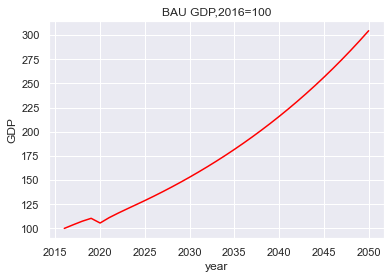

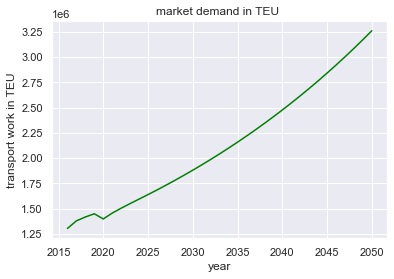

In [25]:
#======> Plotting BAU GDP,2016=100
sns.set()
ax=sns.lineplot(x=year ,y =gdp_sim, color = 'red')
ax.set(xlabel='year', ylabel='GDP')
plt.title("BAU GDP,2016=100" )
plt.show()

#======> Plotting Market Demand Projections in BAU senario: Y
ax=sns.lineplot(x=year ,y = market_demand_sim, color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("market demand in TEU " )
plt.show()

#======> Plotting Marketshare per firm



## a. Firm 1:

In [26]:
 # 7.Get firm passthrough parameter
firm_1_psy_sim = firm_1.get_firm_param(game_config)

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)
print("firm 1 ship energy", firm_1_ship_energy_sim)

firm 1 demand [ 408533.87635978  431982.56102514  444036.3199633   453955.19077289
  437904.39123077  456028.40221777  471287.65864099  485561.17096348
  499495.70061277  513433.30205564  527759.8092163   542486.07386561
  557623.25057518  573182.80516646  589176.52339569  605616.51988116
  622515.24727954  639885.5057183   657740.45249127  676093.61202483
  694958.8861221   714350.56449304  734283.33557831  754772.29767522
  775832.97037412  797481.30631384  819733.70326521  842607.01655175
  866118.5718169   890286.17814752  915128.1415636   940663.27888434
  966910.93198114  993890.98242837 1021623.86656281]
firm 1 ship energy [0.00053659]


In [ ]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_1_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 1 level demand in TEU " )
plt.show()

## b. Firm 2

In [ ]:
# 7.Get firm passthrough parameter
firm_2_psy_sim = firm_2.get_firm_param(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
print("firm 2 ship energy", firm_2_ship_energy_sim)

In [ ]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_2_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 2 level demand in TEU " )
plt.show()

## c. Firm 3

In [ ]:
# 7.Get firm passthrough parameter
firm_3_psy_sim = firm_3.get_firm_param(game_config)

# 7.Get firm level demand  
firm_3_demand_sim = firm_3.get_firm_demand(game_config)
print("firm 3 demand", firm_3_demand_sim)


# 9.Get ship energy efficiency  
firm_3_ship_energy_sim = firm_3.get_ship_energy_efficiency(game_config)
print("firm 3 ship energy", firm_3_ship_energy_sim)

In [ ]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_3_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 3 level demand in TEU " )
plt.show()

##  c. Memership Decision and coalition formation

In [ ]:
initial_carbon_tax_sim = 20 #USD/ton
taxation_scheme_rate_sim = 0.04

In [ ]:
def BAU_emissions_period(p_index):
    results_period = {}
    optimum_solution_period ={}
    carbon_industry_emission_period = 0
    sulfur_industry_emission_period = 0
    for firm_object in (Firm._registry):
        results  = run_evolution(
            populate_func = partial(generate_population,
                                    size=50,
                                    chromo_lower_bound = firm_object.min_speed ,
                                    chromo_upper_bound = firm_object.max_speed, 
                                    planning_horizon = MarketConfig.T),
            fitness_func = partial(fitness,
                                   firm = firm_object,
                                   sim_game = game_config,
                                   max_number_of_vessel = firm_object.max_number_of_vessel,
                                   period_index = my_period_index),
            crossover_func = partial(BLX_alpha_crossover,
                                     chromo_lower_bound= firm_object.min_speed ,
                                     chromo_upper_bound = firm_object.max_speed),
            generation_limit = 100,
            number_of_similarity = 30,
            mutation_func = partial (mutation,
                                     variance = 0.009,
                                     chromo_lower_bound =  firm_object.min_speed,
                                     chromo_upper_bound= firm_object.max_speed,
                                     probability = 0.5))
        results_period["firm" + str(firm_object.index)] = results
        
        # Store Optimum Solution table     
        optimum_solution_period["firm" + str(firm_object.index)] = results_period["firm" + str(firm_object.index)].iloc[[-1]]

        # Compute industry level BAU emissions
        carbon_industry_emission_period += optimum_solution_period["firm" + str(firm_object.index)]["Carbon Emissions"].values
        sulfur_industry_emission_period += optimum_solution_period["firm" + str(firm_object.index)]["Sulfur Emissions"].values
        #print("carbon_industry_emission_period")
    #print(carbon_industry_emission_period)
    return results_period, optimum_solution_period, carbon_industry_emission_period, sulfur_industry_emission_period

In [ ]:
BAU_carbon_pollution_stock = np.zeros(MarketConfig.T+1)
BAU_sulfur_pollution_stock = np.zeros(MarketConfig.T+1)
results = {} #empty dict
optimum_solution={} #empty dict 
for my_period_index in range(MarketConfig.T):
    results_period, optimum_solution_period, carbon_industry_emission_period, sulfur_industry_emission_period = BAU_emissions_period(my_period_index +1)
    results[my_period_index+1]  = results_period
    optimum_solution [my_period_index +1 ] = optimum_solution_period # a dict ''    
    BAU_carbon_pollution_stock[my_period_index + 1] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[my_period_index ] + carbon_industry_emission_period
    BAU_sulfur_pollution_stock[my_period_index+1] = (1- pollution_decay_parameter ) * BAU_sulfur_pollution_stock[my_period_index] + sulfur_industry_emission_period

## c. Compute BAU emissions throughout the planning horizon

In [ ]:
#results[2]["firm1"]

In [ ]:
#optimum_solution[2]['firm1']

## Placeholders Analysis: No carbon emissions constraints policy

In [ ]:
firms = optimum_solution[1].keys()
periodes = optimum_solution.keys()

##### Discounted Period Profits

In [ ]:
Discounted_period_profits = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        Discounted_period_profits[firm][periode] = ((optimum_solution[periode][firm]["Firm Discounted profit"]).values).astype(float)
Discounted_period_profits

#####  Vessel Speed

In [ ]:
Vessel_speed_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        Vessel_speed_optimum[firm][periode] = ((optimum_solution[periode][firm]["Vessel Speed"]).values).astype(float)
Vessel_speed_optimum

#####  Number of vessels

In [ ]:
number_of_vessel_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        number_of_vessel_optimum[firm][periode] = ((optimum_solution[periode][firm]["Number of vessels"]).values).astype(float)
number_of_vessel_optimum

#####  Carbon Emissions Path

In [ ]:
carbon_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in firms:
        carbon_emission[firm][periode] = ((optimum_solution[periode][firm]["Carbon Emissions"]).values).astype(float)

carbon_emission.to_csv("carbonemissionpath")


plt.plot(list(range(1,MarketConfig.T+1)),carbon_emission)
plt.title("Carbon emission path " )
plt.ylabel('Carbon emissions')
plt.legend(labels  =carbon_emission.columns.tolist())
plt.show()

carbon_emission

### Sulfur Emission Path


In [ ]:
sulfur_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in firms:
        sulfur_emission[firm][periode] = ((optimum_solution[periode][firm]["Sulfur Emissions"]).values).astype(float)

        
plt.plot(list(range(1,MarketConfig.T+1)),sulfur_emission)
plt.title("Sulfur emission path " )
plt.ylabel('Sulfur emissions')
plt.legend(labels  = sulfur_emission.columns.tolist())
plt.show()



sulfur_emission.to_csv("sulfuremissionpath")
sulfur_emission

#####  Carbon and Sulfur Pollution Stock

In [ ]:
Pollution_Stock = pd.DataFrame(columns = ["Carbon Pollution Stock", "Sulfur Pollution Stock"] ,  index = periodes )

for periode in periodes:
    Pollution_Stock["Carbon Pollution Stock"][periode] = BAU_carbon_pollution_stock[periode -1]
    Pollution_Stock["Sulfur Pollution Stock"][periode] = BAU_sulfur_pollution_stock[periode -1]

# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel('Carbon Pollution Stock', color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Carbon Pollution Stock"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sulfur Pollution Stock', color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Sulfur Pollution Stock"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Pollution_Stock

#####  Carbon and Sulfur Pollution Damages

In [ ]:
sulfur_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_sulfur_pollution_stock,2)
#sulfur_industry_carbon_damages
BAU_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_carbon_pollution_stock,2)
#BAU_industry_carbon_damages

In [ ]:
Industry_Damages = pd.DataFrame(columns = ["Carbon Industry Damages", "Sulfur Industry Damages "] ,  index = periodes )

for periode in periodes:
    Industry_Damages["Carbon Industry Damages"][periode] = BAU_industry_carbon_damages[periode-1]
    Industry_Damages["Sulfur Industry Damages "][periode] = sulfur_industry_carbon_damages[periode-1]

    
    
# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel("Carbon Industry Damages", color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Carbon Industry Damages"] , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Sulfur Industry Damages ", color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Sulfur Industry Damages "] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Industry_Damages

### Evaluatin GA performance

### Profit,   Revenue, Cost CO2 Cost,  SOx Cos in 1 graph as a function of generation ??

### Firm 1, Period 1

In [ ]:
plt.plot(results[1]["firm1"]['Generation'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Convergence " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Generation')
plt.show()
#############
plt.plot(results[1]["firm1"]['Vessel Speed'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Profits " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Vessel Speed')
plt.show()

## Export Results to spreadsheet

In [ ]:
writer = pd.ExcelWriter('results.xlsx', engine='xlsxwriter')   
for periode in results.keys():
    for firm in results[periode].keys():
        sheet_name = "period" + str(periode) + firm
        results[periode][firm].to_excel(writer, sheet_name = sheet_name, index =False)
writer.save()

In [ ]:
writer_1 = pd.ExcelWriter('optimum_solution.xlsx', engine='xlsxwriter')   
for periode in optimum_solution.keys():
    for firm in optimum_solution[periode].keys():
        sheet_name = "period" + str(periode) + firm
        optimum_solution[periode][firm].to_excel(writer_1, sheet_name = sheet_name, index =False)
writer_1.save()

In [ ]:
#"Singerons are denoted by '0' while signatories are denoted by '1'"
coalition_structure =np.asarray([list(i) for i in itertools.product([0, 1], repeat= number_of_firms)])
All_singelton = coalition_structure[0]
Grand_coalition  = coalition_structure[-1]
coalition_structure
#coalition_stru[3]

In [ ]:
for compteur in range (len(coalition_structure)): 
    coalition = np.where(coalition_structure[compteur] == 1)
    singleton = np.where(coalition_structure[compteur] == 0)
    print(coalition)

## Import BAU emissions, pollution stock and industry damages

### Benefits from abatement 

### coalition model : 
Assume am emission threshold -condition for joining the coalition 

gen = 0
for each species s do begin
Pops(gen) = randomly initialized population
evaluate fitness of each individual in Pops(gen)
end
while termination condition = false do begin
gen = gen + 1
for each species s do begin
select Pops(gen) from Pops(gen − 1) based on fitness
apply genetic operators to Pops(gen)
evaluate fitness of each individual in Pops(gen)
end
end

In [930]:
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'industry_carbon_emission': array([15, 43])},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]},
  'industry_carbon_emission': array([16, 44])},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]},
  'industry_carbon_emission': array([16, 43])},
 {'firm1': {'chromo0': [3, 10]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo1': [8, 18]},
  'industry_carbon_emission': array([17, 44])},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo0': [7, 17]},
  'industry_carbon_emission': array([16, 48])},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo0': [5, 16]},
  'firm3': {'chromo1': [8, 18]},
  'industry_carbon_emission': array([17, 49])},
 {'firm1': {'chromo1': [4, 15]},
  'firm2': {'chromo1': [6, 16]},
  'firm3': {'chromo0': [7, 17]},
  'industry_carbon_

In [932]:
df = pd.DataFrame.from_dict(industry_carbon_emission_combo)
df

,firm1,firm2,firm3,industry_carbon_emission
0,"{'chromo0': [3, 10]}","{'chromo0': [5, 16]}","{'chromo0': [7, 17]}","[15, 43]"
1,"{'chromo0': [3, 10]}","{'chromo0': [5, 16]}","{'chromo1': [8, 18]}","[16, 44]"
2,"{'chromo0': [3, 10]}","{'chromo1': [6, 16]}","{'chromo0': [7, 17]}","[16, 43]"
3,"{'chromo0': [3, 10]}","{'chromo1': [6, 16]}","{'chromo1': [8, 18]}","[17, 44]"
4,"{'chromo1': [4, 15]}","{'chromo0': [5, 16]}","{'chromo0': [7, 17]}","[16, 48]"
5,"{'chromo1': [4, 15]}","{'chromo0': [5, 16]}","{'chromo1': [8, 18]}","[17, 49]"
6,"{'chromo1': [4, 15]}","{'chromo1': [6, 16]}","{'chromo0': [7, 17]}","[17, 48]"
7,"{'chromo1': [4, 15]}","{'chromo1': [6, 16]}","{'chromo1': [8, 18]}","[18, 49]"


# here

In [1033]:
industry_carbon_emission_combo[0]["industry_carbon_emission"]

array([ 15,  43, 120])

In [ ]:
BAU_carbon_pollution_stock
=(1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[my_period_index ] + carbon_industry_emission_period
BAU_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_carbon_pollution_stock,2)


In [1040]:
industry_carbon_emission_combo[0]["carbon_pollution_stock"]=np.zeros(4)
industry_carbon_emission_combo[0]["carbon_pollution_stock"]

array([0., 0., 0., 0.])

In [1041]:
#industry_carbon_emission_combo[0]["carbon_pollution_stock"] = 
x =np.zeros(4)
x = [np.multiply(1- pollution_decay_parameter, x[_]) + industry_carbon_emission_combo[0]["industry_carbon_emission"][_] for _ in range(3)]
x

[15.0, 43.0, 120.0]

In [1028]:
industry_carbon_emission_combo[0]["carbon_pollution_stock"]

[15.0, 43.0, 120.0]

In [1034]:
industry_carbon_emission_combo[0]["industry_carbon_emission"]

array([ 15,  43, 120])

In [1030]:
industry_carbon_emission_combo[0]["carbon_pollution_stock"] = np.concatenate(([0], 
                                                                              industry_carbon_emission_combo[0]["industry_carbon_emission"]))


(1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[0]

NameError: name 'BAU_carbon_pollution_stock' is not defined

In [1014]:
industry_carbon_emission_combo[0]["industry_carbon_emission"] 

array([ 15,  43, 120])

In [ ]:
BAU_carbon_pollution_stock= []

In [1012]:
 np.cumsum(industry_carbon_emission_combo[0]["carbon_pollution_stock"], weights = [2] )

TypeError: _cumsum_dispatcher() got an unexpected keyword argument 'weights'

In [ ]:
#Carbon pollution stock 
BAU_carbon_pollution_stock = 0  
dynamic_tax = np.zeros(planning_horizon +1)
dynamic_tax[0] = initial_carbon_tax_sim

In [ ]:
BAU_carbon_pollution_stock[0] =0

BAU_carbon_pollution_stock[1] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[0] + carbon_industry_emission_period[0]


BAU_carbon_pollution_stock[2] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[1 ] + carbon_industry_emission_period[1]



BAU_carbon_pollution_stock[my_period_index + 1] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[my_period_index ] + carbon_industry_emission_period
BAU_industry_sulfur_damages = 0.5* pollution_damage_parameter * np.power(BAU_sulfur_pollution_stock,2)
            

In [ ]:
BAU_sulfur_pollution_stock[my_period_index+1] = (1- pollution_decay_parameter ) * BAU_sulfur_pollution_stock[my_period_index] + sulfur_industry_emission_period


In [ ]:
dynamic_tax [my_period_index+1] = initial_carbon_tax_sim + taxation_scheme_rate_sim * BAU_carbon_pollution_stock[my_period_index +1 ]
policy_cost = np.multiply(carbon_emissions_sim, dynamic_tax[period_index]) # a numpy vectore
   

In [1066]:
pollution_decay_parameter = 0.5
pollution_damage_parameter = 1
initial_carbon_tax_sim = [2]
taxation_scheme_rate_sim =0.5

In [1075]:
y = np.zeros (2)

np.concatenate([2],y)


TypeError: only integer scalar arrays can be converted to a scalar index

In [1081]:
evolving_species.index

2

In [1099]:
chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_]["firm"+str(evolving_species.index)].items())
firm_carbon_emission

([5, 16, 40],)

In [1101]:
industry_carbon_emission_combo[0]

{'firm1': {'chromo0': [3, 10, 20]},
 'firm2': {'chromo0': [5, 16, 40]},
 'firm3': {'chromo0': [7, 17, 60]},
 'industry_carbon_emission': array([ 15,  43, 120]),
 'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
 'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
 'dynamic_tax': array([ 2.  ,  9.5 , 27.25])}

In [1103]:
np.array(industry_carbon_emission_combo[0]["firm"+str(evolving_species.index)].get(str(chromos[0])))

array([ 5, 16, 40])

In [1089]:
industry_carbon_emission_combo[_]["firm"+str(evolving_species.index)].items()

dict_items([('chromo0', [5, 16, 40])])

In [1085]:
industry_carbon_emission_combo[_]["dynamic_tax"]

array([ 2.  ,  9.5 , 27.25])

In [ ]:
carbon_emissions={}
carbon_emissions["firm1"]={}
carbon_emissions["firm2"]={}
carbon_emissions["firm3"]={}
carbon_emissions["firm1"]["chromo0"]= [3,10,20] 
carbon_emissions["firm1"]["chromo1"]= [4,15,30]
carbon_emissions["firm2"]["chromo0"]= [5,16,40] 
carbon_emissions["firm2"]["chromo1"]= [6,16,50] 
carbon_emissions["firm3"]["chromo0"]= [7,17,60]
carbon_emissions["firm3"]["chromo1"]= [8,18,70]
carbon_emissions
industry_carbon_emission_combo= {}
industry_carbon_emission_combo = [dict(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]
for _ in range(len(industry_carbon_emission_combo)):
    for firm in industry_carbon_emission_combo[_].keys():
        industry_carbon_emission_combo[_].update({str(firm): {str(industry_carbon_emission_combo[_][str(firm)]): 
                                 carbon_emissions[str(firm)][str(industry_carbon_emission_combo[_][str(firm)])]}})
        
        
firms = (tuple(industry_carbon_emission_combo[0].keys()))
firms
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["industry_carbon_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))
        
        
        
        
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["carbon_pollution_stock"] =np.zeros (3)
    industry_carbon_emission_combo[_]["industry_carbon_damages"]= np.zeros (3)
    industry_carbon_emission_combo[_]["carbon_dynamic_tax"]  = np.zeros (3)
    industry_carbon_emission_combo[_]["carbon_dynamic_tax"][0]  = initial_carbon_tax_sim
    
    for my_period_index in range (2): 
        #Remove and multipy instead of using loop 
        industry_carbon_emission_combo[_]["carbon_pollution_stock"] [my_period_index + 1] = (1- pollution_decay_parameter ) * industry_carbon_emission_combo[_]["carbon_pollution_stock"][my_period_index ] + industry_carbon_emission_combo[0]["industry_carbon_emission"][my_period_index]
        industry_carbon_emission_combo[_]["carbon_dynamic_tax"] [my_period_index+1] = initial_carbon_tax_sim + taxation_scheme_rate_sim * industry_carbon_emission_combo[_]["carbon_pollution_stock"][my_period_index +1 ]

    
    industry_carbon_emission_combo[_]["industry_carbon_damages"] = 0.5* pollution_damage_parameter * np.power( industry_carbon_emission_combo[_]["carbon_pollution_stock"],2)

    #Policy and Update Cost 
    chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_]["firm"+str(evolving_species.index)].items())
    print(firm_carbon_emission)
    industry_carbon_emission_combo[_]["carbon_policy_cost"] = np.multiply(firm_carbon_emission[0], 
                                                                industry_carbon_emission_combo[_]["carbon_dynamic_tax"]) # a numpy vectore

        

In [1144]:
carbon_emissions={}
carbon_emissions["firm1"]={}
carbon_emissions["firm2"]={}
carbon_emissions["firm3"]={}
carbon_emissions["firm1"]["chromo0"]= [3,10,20] 
carbon_emissions["firm1"]["chromo1"]= [4,15,30]
carbon_emissions["firm2"]["chromo0"]= [5,16,40] 
carbon_emissions["firm2"]["chromo1"]= [6,16,50] 
carbon_emissions["firm3"]["chromo0"]= [7,17,60]
carbon_emissions["firm3"]["chromo1"]= [8,18,70]
carbon_emissions

{'firm1': {'chromo0': [3, 10, 20], 'chromo1': [4, 15, 30]},
 'firm2': {'chromo0': [5, 16, 40], 'chromo1': [6, 16, 50]},
 'firm3': {'chromo0': [7, 17, 60], 'chromo1': [8, 18, 70]}}

In [1145]:
industry_carbon_emission_combo= {}

In [1146]:
industry_carbon_emission_combo = [dict(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]
for _ in range(len(industry_carbon_emission_combo)):
    for firm in industry_carbon_emission_combo[_].keys():
        industry_carbon_emission_combo[_].update({str(firm): {str(industry_carbon_emission_combo[_][str(firm)]): 
                                 carbon_emissions[str(firm)][str(industry_carbon_emission_combo[_][str(firm)])]}})

In [1147]:
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo0': [7, 17, 60]}},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo1': [8, 18, 70]}},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo0': [7, 17, 60]}},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo1': [8, 18, 70]}},
 {'firm1': {'chromo1': [4, 15, 30]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo0': [7, 17, 60]}},
 {'firm1': {'chromo1': [4, 15, 30]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo1': [8, 18, 70]}},
 {'firm1': {'chromo1': [4, 15, 30]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo0': [7, 17, 60]}},
 {'firm1': {'chromo1': [4, 15, 30]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo1': [8, 18, 70]}}]

In [1148]:
firms = (tuple(industry_carbon_emission_combo[0].keys()))
firms

('firm1', 'firm2', 'firm3')

In [1149]:
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["industry_carbon_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))


In [1150]:
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["industry_carbon_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))
        
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 15,  43, 120])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo1': [8, 18, 70]},
  'industry_carbon_emission': array([ 16,  44, 130])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 16,  43, 130])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo1': [8, 18, 70]},
  'industry_carbon_emission': array([ 17,  44, 140])},
 {'firm1': {'chromo1': [4, 15, 30]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 16,  48, 130])},
 {'firm1': {'chromo1': [4, 15, 30]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo1': [8, 18, 70]},
  'industry_carbon_emission': array([ 17,  49, 140])},
 {'f

In [1151]:
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["carbon_pollution_stock"] =np.zeros (3)
    industry_carbon_emission_combo[_]["industry_carbon_damages"]= np.zeros (3)
    industry_carbon_emission_combo[_]["carbon_dynamic_tax"]  = np.zeros (3)
    industry_carbon_emission_combo[_]["carbon_dynamic_tax"][0]  = initial_carbon_tax_sim
    
    for my_period_index in range (2): 
        #Remove and multipy instead of using loop 
        industry_carbon_emission_combo[_]["carbon_pollution_stock"] [my_period_index + 1] = (1- pollution_decay_parameter ) * industry_carbon_emission_combo[_]["carbon_pollution_stock"][my_period_index ] + industry_carbon_emission_combo[0]["industry_carbon_emission"][my_period_index]
        industry_carbon_emission_combo[_]["carbon_dynamic_tax"] [my_period_index+1] = initial_carbon_tax_sim + taxation_scheme_rate_sim * industry_carbon_emission_combo[_]["carbon_pollution_stock"][my_period_index +1 ]

    
    industry_carbon_emission_combo[_]["industry_carbon_damages"] = 0.5* pollution_damage_parameter * np.power( industry_carbon_emission_combo[_]["carbon_pollution_stock"],2)

    #Policy and Update Cost 
    chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_]["firm"+str(evolving_species.index)].items())
    print(firm_carbon_emission)
    industry_carbon_emission_combo[_]["carbon_policy_cost"] = np.multiply(firm_carbon_emission[0], 
                                                                industry_carbon_emission_combo[_]["carbon_dynamic_tax"]) # a numpy vectore




#BAU_sulfur_pollution_stock[my_period_index+1] = (1- pollution_decay_parameter ) * BAU_sulfur_pollution_stock[my_period_index] + sulfur_industry_emission_period
#             BAU_industry_sulfur_damages = 0.5* pollution_damage_parameter * np.power(BAU_sulfur_pollution_stock,2)
#            

([5, 16, 40],)
([5, 16, 40],)
([6, 16, 50],)
([6, 16, 50],)
([5, 16, 40],)
([5, 16, 40],)
([6, 16, 50],)
([6, 16, 50],)


In [1153]:
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 15,  43, 120]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo1': [8, 18, 70]},
  'industry_carbon_emission': array([ 16,  44, 130]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 16,  43, 130]),
  'carbon_pollution_stock': array([ 0. , 

In [1154]:
pd.DataFrame.from_dict(industry_carbon_emission_combo)

,firm1,firm2,firm3,industry_carbon_emission,carbon_pollution_stock,industry_carbon_damages,carbon_dynamic_tax,carbon_policy_cost
0,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
1,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
2,"{'chromo0': [3, 10, 20]}","{'chromo1': [6, 16, 50]}","{'chromo0': [7, 17, 60]}","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
3,"{'chromo0': [3, 10, 20]}","{'chromo1': [6, 16, 50]}","{'chromo1': [8, 18, 70]}","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
4,"{'chromo1': [4, 15, 30]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
5,"{'chromo1': [4, 15, 30]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
6,"{'chromo1': [4, 15, 30]}","{'chromo1': [6, 16, 50]}","{'chromo0': [7, 17, 60]}","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
7,"{'chromo1': [4, 15, 30]}","{'chromo1': [6, 16, 50]}","{'chromo1': [8, 18, 70]}","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"


In [1165]:
evolving_species_sim ={}

In [1168]:
evolving_species_sim ["selected_chromo"] = [2, 2, 2]
evolving_species_sim ["number_vessels_sim"] = [2, 2, 2]
evolving_species_sim["main_fuel_con_sim"]  = [2, 2, 2]
evolving_species_sim["aux_fuel_con_sim"]  =[2, 2, 2]
evolving_species_sim["fuel_cost_sim"]  =[2, 2, 2]
evolving_species_sim ["total_cost_sim"]  = [2, 2, 2]
evolving_species_sim ["revenue_sim"] =[2, 2, 2]
evolving_species_sim["profit_vector_sim"] = [2, 2, 2]


In [1169]:
evolving_species_sim

{'slected_chromo': [2, 2, 2],
 'number_vessels_sim': [2, 2, 2],
 'main_fuel_con_sim': [2, 2, 2],
 'aux_fuel_con_sim': [2, 2, 2],
 'fuel_cost_sim': [2, 2, 2],
 'total_cost_sim': [2, 2, 2],
 'revenue_sim': [2, 2, 2],
 'profit_vector_sim': [2, 2, 2],
 'selected_chromo': [2, 2, 2]}

In [1170]:
industry_carbon_emission_combo

[{'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 15,  43, 120]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo1': [8, 18, 70]},
  'industry_carbon_emission': array([ 16,  44, 130]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 16,  43, 130]),
  'carbon_pollution_stock': array([ 0. , 

In [1172]:
industry_sulfur_emission_combo = industry_carbon_emission_combo
industry_sulfur_emission_combo

[{'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 15,  43, 120]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo0': [5, 16, 40]},
  'firm3': {'chromo1': [8, 18, 70]},
  'industry_carbon_emission': array([ 16,  44, 130]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.])},
 {'firm1': {'chromo0': [3, 10, 20]},
  'firm2': {'chromo1': [6, 16, 50]},
  'firm3': {'chromo0': [7, 17, 60]},
  'industry_carbon_emission': array([ 16,  43, 130]),
  'carbon_pollution_stock': array([ 0. , 

In [1190]:
bla = industry_carbon_emission_combo + industry_sulfur_emission_combo

In [1192]:
pd.DataFrame.from_dict(bla)

,firm1,firm2,firm3,industry_carbon_emission,carbon_pollution_stock,industry_carbon_damages,carbon_dynamic_tax,carbon_policy_cost
0,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
1,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
2,"{'chromo0': [3, 10, 20]}","{'chromo1': [6, 16, 50]}","{'chromo0': [7, 17, 60]}","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
3,"{'chromo0': [3, 10, 20]}","{'chromo1': [6, 16, 50]}","{'chromo1': [8, 18, 70]}","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
4,"{'chromo1': [4, 15, 30]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
5,"{'chromo1': [4, 15, 30]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
6,"{'chromo1': [4, 15, 30]}","{'chromo1': [6, 16, 50]}","{'chromo0': [7, 17, 60]}","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
7,"{'chromo1': [4, 15, 30]}","{'chromo1': [6, 16, 50]}","{'chromo1': [8, 18, 70]}","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
8,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
9,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"


In [ ]:
candidate_partner_chromo["firm"] = np.reshape(symbiotic_neighberhood["firm" + str(_.index) ], (9, 2)) #(l*m, n)


In [1174]:
candidate_partner_chromo={}
candidate_partner_chromo["firm1"]=[8,18,70]
candidate_partner_chromo["firm2"]=[8,18,70]
candidate_partner_chromo["firm3"]= [8,18,70]
candidate_partner_chromo

{'firm1': [8, 18, 70], 'firm2': [8, 18, 70], 'firm3': [8, 18, 70]}

In [1177]:
symbiotic_neighberhood["firm1" ]

array([[[11.35650611, 11.51352875],
        [11.99289141, 10.24770857],
        [10.9682427 , 11.28989747]],

       [[10.01660715, 10.67203462],
        [11.20258701, 11.15884496],
        [11.81119978, 10.90737755]],

       [[10.43582625, 10.82993221],
        [11.16172744, 10.21555924],
        [11.06490624, 10.07445328]]])

In [1180]:
symbiotic_neighberhood["firm3" ] = symbiotic_neighberhood["firm1" ]

In [1250]:
symbiotic_neighberhood["firm2" ] = symbiotic_neighberhood["firm1" ]

In [1181]:
candidate_partner_chromo={}
for _ in (symbiotic_species):
    candidate_partner_chromo["firm" + str(_.index)] = np.reshape(symbiotic_neighberhood["firm" + str(_.index) ], (9, 2)) #(l*m, n)


In [1188]:
candidate_partner_chromo['firm1']

array([[11.35650611, 11.51352875],
       [11.99289141, 10.24770857],
       [10.9682427 , 11.28989747],
       [10.01660715, 10.67203462],
       [11.20258701, 11.15884496],
       [11.81119978, 10.90737755],
       [10.43582625, 10.82993221],
       [11.16172744, 10.21555924],
       [11.06490624, 10.07445328]])

In [1254]:
candidate_partner_chromo['firm2'] = candidate_partner_chromo['firm1']
candidate_partner_chromo

{'firm1': array([[11.35650611, 11.51352875],
        [11.99289141, 10.24770857],
        [10.9682427 , 11.28989747],
        [10.01660715, 10.67203462],
        [11.20258701, 11.15884496],
        [11.81119978, 10.90737755],
        [10.43582625, 10.82993221],
        [11.16172744, 10.21555924],
        [11.06490624, 10.07445328]]),
 'firm3': array([[11.35650611, 11.51352875],
        [11.99289141, 10.24770857],
        [10.9682427 , 11.28989747],
        [10.01660715, 10.67203462],
        [11.20258701, 11.15884496],
        [11.81119978, 10.90737755],
        [10.43582625, 10.82993221],
        [11.16172744, 10.21555924],
        [11.06490624, 10.07445328]]),
 'firm2': array([[11.35650611, 11.51352875],
        [11.99289141, 10.24770857],
        [10.9682427 , 11.28989747],
        [10.01660715, 10.67203462],
        [11.20258701, 11.15884496],
        [11.81119978, 10.90737755],
        [10.43582625, 10.82993221],
        [11.16172744, 10.21555924],
        [11.06490624, 10.07445328

In [1185]:
chromo_0 #chromo_0 = candidate_partner_chromo['firm1'][0]

array([11.35650611, 11.51352875])

In [1194]:
initial_sulfur_tax_sim = 2

In [1344]:
sulfur_emissions={}
sulfur_emissions["firm1"]={}
sulfur_emissions["firm2"]={}
sulfur_emissions["firm3"]={}
sulfur_emissions["firm1"]["chromo0"]= [3,10,20] 
sulfur_emissions["firm1"]["chromo1"]= [4,15,30]
sulfur_emissions["firm2"]["chromo0"]= [5,16,40] 
sulfur_emissions["firm2"]["chromo1"]= [6,16,50] 
sulfur_emissions["firm3"]["chromo0"]= [7,17,60]
sulfur_emissions["firm3"]["chromo1"]= [8,18,70]
sulfur_emissions
industry_sulfur_emission_combo= {}
industry_sulfur_emission_combo = [dict(zip(sulfur_emissions.keys(), a)) for a in itertools.product(*sulfur_emissions.values())]
for _ in range(len(industry_sulfur_emission_combo)):
    for firm in industry_sulfur_emission_combo[_].keys():
        industry_sulfur_emission_combo[_].update({str(firm): {str(industry_sulfur_emission_combo[_][str(firm)]): 
                                 sulfur_emissions[str(firm)][str(industry_sulfur_emission_combo[_][str(firm)])]}})
        
        
firms = (tuple(industry_sulfur_emission_combo[0].keys()))
firms
for _ in range(len(industry_sulfur_emission_combo)):
    industry_sulfur_emission_combo[_]["industry_sulfur_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_sulfur_emission = zip(*industry_sulfur_emission_combo[_][str(firm)].items())
        industry_sulfur_emission_combo[_]["industry_sulfur_emission"] += np.array(industry_sulfur_emission_combo[_].get(str(firm)).get(str(chromos[0])))
        
        
        
        
for _ in range(len(industry_sulfur_emission_combo)):
    industry_sulfur_emission_combo[_]["sulfur_pollution_stock"] =np.zeros (3)
    industry_sulfur_emission_combo[_]["industry_sulfur_damages"]= np.zeros (3)
    industry_sulfur_emission_combo[_]["sulfur_dynamic_tax"]  = np.zeros (3)
    industry_sulfur_emission_combo[_]["sulfur_dynamic_tax"][0]  = initial_sulfur_tax_sim
    
    for my_period_index in range (2): 
        #Remove and multipy instead of using loop 
        industry_sulfur_emission_combo[_]["sulfur_pollution_stock"] [my_period_index + 1] = (1- pollution_decay_parameter ) * industry_sulfur_emission_combo[_]["sulfur_pollution_stock"][my_period_index ] + industry_sulfur_emission_combo[0]["industry_sulfur_emission"][my_period_index]
        industry_sulfur_emission_combo[_]["sulfur_dynamic_tax"] [my_period_index+1] = initial_sulfur_tax_sim + taxation_scheme_rate_sim * industry_sulfur_emission_combo[_]["sulfur_pollution_stock"][my_period_index +1 ]

    
    industry_sulfur_emission_combo[_]["industry_sulfur_damages"] = 0.5* pollution_damage_parameter * np.power( industry_sulfur_emission_combo[_]["sulfur_pollution_stock"],2)

    #Policy and Update Cost 
    chromos, firm_sulfur_emission = zip(*industry_sulfur_emission_combo[_]["firm"+str(evolving_species.index)].items())
    print(firm_sulfur_emission)
    industry_sulfur_emission_combo[_]["sulfur_policy_cost"] = np.multiply(firm_sulfur_emission[0], 
                                                                industry_sulfur_emission_combo[_]["sulfur_dynamic_tax"]) # a numpy vectore

pd.DataFrame.from_dict(industry_sulfur_emission_combo)

([5, 16, 40],)
([5, 16, 40],)
([6, 16, 50],)
([6, 16, 50],)
([5, 16, 40],)
([5, 16, 40],)
([6, 16, 50],)
([6, 16, 50],)


,firm1,firm2,firm3,industry_sulfur_emission,sulfur_pollution_stock,industry_sulfur_damages,sulfur_dynamic_tax,sulfur_policy_cost
0,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
1,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
2,"{'chromo0': [3, 10, 20]}","{'chromo1': [6, 16, 50]}","{'chromo0': [7, 17, 60]}","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
3,"{'chromo0': [3, 10, 20]}","{'chromo1': [6, 16, 50]}","{'chromo1': [8, 18, 70]}","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
4,"{'chromo1': [4, 15, 30]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
5,"{'chromo1': [4, 15, 30]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
6,"{'chromo1': [4, 15, 30]}","{'chromo1': [6, 16, 50]}","{'chromo0': [7, 17, 60]}","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
7,"{'chromo1': [4, 15, 30]}","{'chromo1': [6, 16, 50]}","{'chromo1': [8, 18, 70]}","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"


In [1358]:
carbon_emissions={}
carbon_emissions["firm1"]={}
carbon_emissions["firm2"]={}
carbon_emissions["firm3"]={}
carbon_emissions["firm1"]["chromo0"]= [3,10,20] 
carbon_emissions["firm1"]["chromo1"]= [4,15,30]
carbon_emissions["firm2"]["chromo0"]= [5,16,40] 
carbon_emissions["firm2"]["chromo1"]= [6,16,50] 
carbon_emissions["firm3"]["chromo0"]= [7,17,60]
carbon_emissions["firm3"]["chromo1"]= [8,18,70]
carbon_emissions
industry_carbon_emission_combo= {}
industry_carbon_emission_combo = [dict(zip(carbon_emissions.keys(), a)) for a in itertools.product(*carbon_emissions.values())]
for _ in range(len(industry_carbon_emission_combo)):
    for firm in industry_carbon_emission_combo[_].keys():
        industry_carbon_emission_combo[_].update({str(firm): {str(industry_carbon_emission_combo[_][str(firm)]): 
                                 carbon_emissions[str(firm)][str(industry_carbon_emission_combo[_][str(firm)])]}})
        
        
firms = (tuple(industry_carbon_emission_combo[0].keys()))
firms
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["industry_carbon_emission"] = 0
    for firm in firms:
        #print(firm)
        chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_]["industry_carbon_emission"] += np.array(industry_carbon_emission_combo[_].get(str(firm)).get(str(chromos[0])))
        
        
        
        
for _ in range(len(industry_carbon_emission_combo)):
    industry_carbon_emission_combo[_]["carbon_pollution_stock"] =np.zeros (3)
    industry_carbon_emission_combo[_]["industry_carbon_damages"]= np.zeros (3)
    industry_carbon_emission_combo[_]["carbon_dynamic_tax"]  = np.zeros (3)
    industry_carbon_emission_combo[_]["carbon_dynamic_tax"][0]  = initial_carbon_tax_sim
    
    for my_period_index in range (2): 
        #Remove and multipy instead of using loop 
        industry_carbon_emission_combo[_]["carbon_pollution_stock"] [my_period_index + 1] = (1- pollution_decay_parameter ) * industry_carbon_emission_combo[_]["carbon_pollution_stock"][my_period_index ] + industry_carbon_emission_combo[0]["industry_carbon_emission"][my_period_index]
        industry_carbon_emission_combo[_]["carbon_dynamic_tax"] [my_period_index+1] = initial_carbon_tax_sim + taxation_scheme_rate_sim * industry_carbon_emission_combo[_]["carbon_pollution_stock"][my_period_index +1 ]

    
    industry_carbon_emission_combo[_]["industry_carbon_damages"] = 0.5* pollution_damage_parameter * np.power( industry_carbon_emission_combo[_]["carbon_pollution_stock"],2)

    #Policy and Update Cost 
    chromos, firm_carbon_emission = zip(*industry_carbon_emission_combo[_]["firm"+str(evolving_species.index)].items())
    print(firm_carbon_emission)
    industry_carbon_emission_combo[_]["carbon_policy_cost"] = np.multiply(firm_carbon_emission[0], 
                                                                industry_carbon_emission_combo[_]["carbon_dynamic_tax"]) # a numpy vectore

pd.DataFrame.from_dict(industry_carbon_emission_combo)        

([5, 16, 40],)
([5, 16, 40],)
([6, 16, 50],)
([6, 16, 50],)
([5, 16, 40],)
([5, 16, 40],)
([6, 16, 50],)
([6, 16, 50],)


,firm1,firm2,firm3,industry_carbon_emission,carbon_pollution_stock,industry_carbon_damages,carbon_dynamic_tax,carbon_policy_cost
0,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
1,"{'chromo0': [3, 10, 20]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
2,"{'chromo0': [3, 10, 20]}","{'chromo1': [6, 16, 50]}","{'chromo0': [7, 17, 60]}","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
3,"{'chromo0': [3, 10, 20]}","{'chromo1': [6, 16, 50]}","{'chromo1': [8, 18, 70]}","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
4,"{'chromo1': [4, 15, 30]}","{'chromo0': [5, 16, 40]}","{'chromo0': [7, 17, 60]}","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
5,"{'chromo1': [4, 15, 30]}","{'chromo0': [5, 16, 40]}","{'chromo1': [8, 18, 70]}","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
6,"{'chromo1': [4, 15, 30]}","{'chromo1': [6, 16, 50]}","{'chromo0': [7, 17, 60]}","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
7,"{'chromo1': [4, 15, 30]}","{'chromo1': [6, 16, 50]}","{'chromo1': [8, 18, 70]}","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"


In [1359]:
industry_carbon_emission_combo[0]["firm1"]['chromo0'] = candidate_partner_chromo['firm1'][0]

In [1360]:
for _ in range(len(industry_carbon_emission_combo)):
    for firm in firms:
        chromos, chromo_tobe_updated = zip(*industry_carbon_emission_combo[_][str(firm)].items())
        industry_carbon_emission_combo[_][str(firm)][str(chromos[0])] = candidate_partner_chromo[str(firm)][int(re.findall(r'\d+', chromos[0])[0])]

In [1361]:
chromos, chromo_tobe_updated = zip(*industry_carbon_emission_combo[_][str(firm)].items())


In [1362]:
chromos[0]

'chromo1'

In [1363]:
firm_carbon_emission

([6, 16, 50],)

In [1364]:
import re

int(re.findall(r'\d+', chromos[0])[0])


1

In [1365]:
for _ in range(len(industry_sulfur_emission_combo)):
    for firm in firms:
        chromos, chromo_tobe_updated = zip(*industry_sulfur_emission_combo[_][str(firm)].items())
        industry_sulfur_emission_combo[_][str(firm)][str(chromos[0])] = candidate_partner_chromo[str(firm)][int(re.findall(r'\d+', chromos[0])[0])]
    

In [1366]:
pollution_analysis = [{**a, **b} for a, b in zip(industry_carbon_emission_combo, industry_sulfur_emission_combo)]
pollution_analysis

[{'firm1': {'chromo0': array([11.35650611, 11.51352875])},
  'firm2': {'chromo0': array([11.35650611, 11.51352875])},
  'firm3': {'chromo0': array([11.35650611, 11.51352875])},
  'industry_carbon_emission': array([ 15,  43, 120]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.]),
  'industry_sulfur_emission': array([ 15,  43, 120]),
  'sulfur_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_sulfur_damages': array([   0.   ,  112.5  , 1275.125]),
  'sulfur_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'sulfur_policy_cost': array([  10.,  152., 1090.])},
 {'firm1': {'chromo0': array([11.35650611, 11.51352875])},
  'firm2': {'chromo0': array([11.35650611, 11.51352875])},
  'firm3': {'chromo1': array([11.99289141, 10.24770857])},
  'industry_carbon_emission': array([ 16,  44, 130]),
  'carbon_pollution_s

In [1367]:
pd.DataFrame(pollution_analysis)

,firm1,firm2,firm3,industry_carbon_emission,carbon_pollution_stock,industry_carbon_damages,carbon_dynamic_tax,carbon_policy_cost,industry_sulfur_emission,sulfur_pollution_stock,industry_sulfur_damages,sulfur_dynamic_tax,sulfur_policy_cost
0,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
1,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
2,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
3,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
4,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
5,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]"
6,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"
7,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]"


In [1368]:
#combine policy cost 
for _ in range(len(pollution_analysis)):
    pollution_analysis[_]["policy_cost"] = pollution_analysis[_]["carbon_policy_cost"]+ pollution_analysis[_]["sulfur_policy_cost"] 

In [1369]:
pollution_analysis

[{'firm1': {'chromo0': array([11.35650611, 11.51352875])},
  'firm2': {'chromo0': array([11.35650611, 11.51352875])},
  'firm3': {'chromo0': array([11.35650611, 11.51352875])},
  'industry_carbon_emission': array([ 15,  43, 120]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.]),
  'industry_sulfur_emission': array([ 15,  43, 120]),
  'sulfur_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_sulfur_damages': array([   0.   ,  112.5  , 1275.125]),
  'sulfur_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'sulfur_policy_cost': array([  10.,  152., 1090.]),
  'policy_cost': array([  20.,  304., 2180.])},
 {'firm1': {'chromo0': array([11.35650611, 11.51352875])},
  'firm2': {'chromo0': array([11.35650611, 11.51352875])},
  'firm3': {'chromo1': array([11.99289141, 10.24770857])},
  'industry_carbon_emission'

In [1370]:
pd.DataFrame(pollution_analysis)

,firm1,firm2,firm3,industry_carbon_emission,carbon_pollution_stock,industry_carbon_damages,carbon_dynamic_tax,carbon_policy_cost,industry_sulfur_emission,sulfur_pollution_stock,industry_sulfur_damages,sulfur_dynamic_tax,sulfur_policy_cost,policy_cost
0,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]"
1,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]"
2,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]"
3,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]"
4,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]"
5,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]"
6,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]"
7,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]"


In [1373]:
discount_multiplier = np.power( 1+ game_config.discount_rate, - np.arange(1,3 + 1))

In [1374]:
discount_multiplier

array([0.98039216, 0.96116878, 0.94232233])

In [1380]:
evolving_species_sim["profit_vector_sim"] = 100
evolving_species_sim

{'slected_chromo': [2, 2, 2],
 'number_vessels_sim': [2, 2, 2],
 'main_fuel_con_sim': [2, 2, 2],
 'aux_fuel_con_sim': [2, 2, 2],
 'fuel_cost_sim': [2, 2, 2],
 'total_cost_sim': [2, 2, 2],
 'revenue_sim': [2, 2, 2],
 'profit_vector_sim': 100,
 'selected_chromo': [2, 2, 2]}

In [1384]:
for _ in range(len(pollution_analysis)):
    pollution_analysis[_]["policy_cost"] = pollution_analysis[_]["carbon_policy_cost"]+ pollution_analysis[_]["sulfur_policy_cost"] 
    pollution_analysis[_]["period_profit"] = evolving_species_sim["profit_vector_sim"] -  pollution_analysis[_]["policy_cost"]
    print(pollution_analysis[_]["period_profit"])
    pollution_analysis[_]["discounted_period_profit"]=  np.multiply( discount_multiplier,pollution_analysis[_]["period_profit"]  ) 
    print(pollution_analysis[_]["discounted_period_profit"])
    pollution_analysis[_]["NPV"]= np.sum(pollution_analysis[_]["discounted_period_profit"])
    print(pollution_analysis[_]["NPV"])


[   80.  -204. -2080.]
[   78.43137255  -196.07843137 -1960.03045586]
-2077.677514681382
[   80.  -204. -2080.]
[   78.43137255  -196.07843137 -1960.03045586]
-2077.677514681382
[   76.  -204. -2625.]
[   74.50980392  -196.07843137 -2473.59612819]
-2595.164755636972
[   76.  -204. -2625.]
[   74.50980392  -196.07843137 -2473.59612819]
-2595.164755636972
[   80.  -204. -2080.]
[   78.43137255  -196.07843137 -1960.03045586]
-2077.677514681382
[   80.  -204. -2080.]
[   78.43137255  -196.07843137 -1960.03045586]
-2077.677514681382
[   76.  -204. -2625.]
[   74.50980392  -196.07843137 -2473.59612819]
-2595.164755636972
[   76.  -204. -2625.]
[   74.50980392  -196.07843137 -2473.59612819]
-2595.164755636972


In [1385]:
pollution_analysis

[{'firm1': {'chromo0': array([11.35650611, 11.51352875])},
  'firm2': {'chromo0': array([11.35650611, 11.51352875])},
  'firm3': {'chromo0': array([11.35650611, 11.51352875])},
  'industry_carbon_emission': array([ 15,  43, 120]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.]),
  'industry_sulfur_emission': array([ 15,  43, 120]),
  'sulfur_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_sulfur_damages': array([   0.   ,  112.5  , 1275.125]),
  'sulfur_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'sulfur_policy_cost': array([  10.,  152., 1090.]),
  'policy_cost': array([  20.,  304., 2180.]),
  'period_profit': array([   80.,  -204., -2080.]),
  'discounted_period_profit': array([   78.43137255,  -196.07843137, -1960.03045586]),
  'NPV': -2077.677514681382},
 {'firm1': {'chromo0': array([11.3565

In [1386]:
pd.DataFrame(pollution_analysis)

,firm1,firm2,firm3,industry_carbon_emission,carbon_pollution_stock,industry_carbon_damages,carbon_dynamic_tax,carbon_policy_cost,industry_sulfur_emission,sulfur_pollution_stock,industry_sulfur_damages,sulfur_dynamic_tax,sulfur_policy_cost,policy_cost,period_profit,discounted_period_profit,NPV
0,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]","[80.0, -204.0, -2080.0]","[78.4313725490196, -196.078431372549, -1960.03...",-2077.677515
1,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]","[80.0, -204.0, -2080.0]","[78.4313725490196, -196.078431372549, -1960.03...",-2077.677515
2,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]","[76.0, -204.0, -2625.0]","[74.50980392156862, -196.078431372549, -2473.5...",-2595.164756
3,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]","[76.0, -204.0, -2625.0]","[74.50980392156862, -196.078431372549, -2473.5...",-2595.164756
4,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]","[80.0, -204.0, -2080.0]","[78.4313725490196, -196.078431372549, -1960.03...",-2077.677515
5,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]","[80.0, -204.0, -2080.0]","[78.4313725490196, -196.078431372549, -1960.03...",-2077.677515
6,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]","[76.0, -204.0, -2625.0]","[74.50980392156862, -196.078431372549, -2473.5...",-2595.164756
7,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","

In [1387]:
def getNPV(elem):
    return elem["NPV"]

In [1400]:
integrated_solution_list = sorted(pollution_analysis, key=getNPV, reverse = True )

In [1397]:
x

[{'firm1': {'chromo0': array([11.35650611, 11.51352875])},
  'firm2': {'chromo0': array([11.35650611, 11.51352875])},
  'firm3': {'chromo0': array([11.35650611, 11.51352875])},
  'industry_carbon_emission': array([ 15,  43, 120]),
  'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
  'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'carbon_policy_cost': array([  10.,  152., 1090.]),
  'industry_sulfur_emission': array([ 15,  43, 120]),
  'sulfur_pollution_stock': array([ 0. , 15. , 50.5]),
  'industry_sulfur_damages': array([   0.   ,  112.5  , 1275.125]),
  'sulfur_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
  'sulfur_policy_cost': array([  10.,  152., 1090.]),
  'policy_cost': array([  20.,  304., 2180.]),
  'period_profit': array([   80.,  -204., -2080.]),
  'discounted_period_profit': array([   78.43137255,  -196.07843137, -1960.03045586]),
  'NPV': -2077.677514681382},
 {'firm1': {'chromo0': array([11.3565

In [1398]:
pd.DataFrame(x)

,firm1,firm2,firm3,industry_carbon_emission,carbon_pollution_stock,industry_carbon_damages,carbon_dynamic_tax,carbon_policy_cost,industry_sulfur_emission,sulfur_pollution_stock,industry_sulfur_damages,sulfur_dynamic_tax,sulfur_policy_cost,policy_cost,period_profit,discounted_period_profit,NPV
0,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[15, 43, 120]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]","[80.0, -204.0, -2080.0]","[78.4313725490196, -196.078431372549, -1960.03...",-2077.677515
1,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[16, 44, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]","[80.0, -204.0, -2080.0]","[78.4313725490196, -196.078431372549, -1960.03...",-2077.677515
2,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo0': [11.35650610807846, 11.51352875056...","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[16, 48, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]","[80.0, -204.0, -2080.0]","[78.4313725490196, -196.078431372549, -1960.03...",-2077.677515
3,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[17, 49, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[10.0, 152.0, 1090.0]","[20.0, 304.0, 2180.0]","[80.0, -204.0, -2080.0]","[78.4313725490196, -196.078431372549, -1960.03...",-2077.677515
4,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[16, 43, 130]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]","[76.0, -204.0, -2625.0]","[74.50980392156862, -196.078431372549, -2473.5...",-2595.164756
5,"{'chromo0': [11.35650610807846, 11.51352875056...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[17, 44, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]","[76.0, -204.0, -2625.0]","[74.50980392156862, -196.078431372549, -2473.5...",-2595.164756
6,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo0': [11.35650610807846, 11.51352875056...","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[17, 48, 140]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[24.0, 304.0, 2725.0]","[76.0, -204.0, -2625.0]","[74.50980392156862, -196.078431372549, -2473.5...",-2595.164756
7,"{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","{'chromo1': [11.992891407021851, 10.2477085746...","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","[2.0, 9.5, 27.25]","[12.0, 152.0, 1362.5]","[18, 49, 150]","[0.0, 15.0, 50.5]","[0.0, 112.5, 1275.125]","

In [1399]:
x[0]

{'firm1': {'chromo0': array([11.35650611, 11.51352875])},
 'firm2': {'chromo0': array([11.35650611, 11.51352875])},
 'firm3': {'chromo0': array([11.35650611, 11.51352875])},
 'industry_carbon_emission': array([ 15,  43, 120]),
 'carbon_pollution_stock': array([ 0. , 15. , 50.5]),
 'industry_carbon_damages': array([   0.   ,  112.5  , 1275.125]),
 'carbon_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
 'carbon_policy_cost': array([  10.,  152., 1090.]),
 'industry_sulfur_emission': array([ 15,  43, 120]),
 'sulfur_pollution_stock': array([ 0. , 15. , 50.5]),
 'industry_sulfur_damages': array([   0.   ,  112.5  , 1275.125]),
 'sulfur_dynamic_tax': array([ 2.  ,  9.5 , 27.25]),
 'sulfur_policy_cost': array([  10.,  152., 1090.]),
 'policy_cost': array([  20.,  304., 2180.]),
 'period_profit': array([   80.,  -204., -2080.]),
 'discounted_period_profit': array([   78.43137255,  -196.07843137, -1960.03045586]),
 'NPV': -2077.677514681382}

In [ ]:
def Coevo_GA(populate_func: PopulateFunc,
             fitness_func: FitnessFunc, 
             crossover_func: CrossoverFunc,
             mutation_func: MutationFunc, 
             generation_limit: int = 1000, 
             number_of_similarity: int = 50, 
             selection_func: SelectionFunc = selection_pair):

#I.Initialisation :
    #1.Initilise population for each player and map population into a 2x2 lattice ; each chromo must have T genes 
    #2.map The population of each player into toroidal grids 
      # each population represents the coevolving solution communicating with other population,
     #Each of the populations forms a two-dimensional structure of toroidal square lattic
    #result :  3 population 
    population = {}
    
    for firm_object in (Firm._registry):
        population["firm" + str(firm_object.index)] = (populate_func(fitness_func,firm_object)).reshape(int(np.sqrt(size)),
                                                                                                             int(np.sqrt(size)),
                                                                                                             planning_horizon)#(sqrt(pop size) , sqrt(pop size), #of periods )
###   
  
#II. Initial fitness evaluation   
    #======#
    # Evaluate each chromo such that it is combined with all symbiotic partners that are located at the same position in all of the other populations.
    #get chromo list 
    
    
    #Set fbest to be the fitnesss of the best combination.
    
    
    
    
    
    
    
    #======#
    
    
# Run the coevolutionnary loop / the evolution of populations:While one population evolves, it interacts with the other population. 
#while (number_of_generation < generation_limit) or (chromo_deviation_chech() > deviation_threshold);
        # the coevolving process runs for a predefined number of generations:
        # the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ) == false:
        
while () or () :       
        
    #III. Neighbehood construction : 
        #1. Randomly select a firm, h.,ie the evolving spiecees.
            #identify the remainder as symbiotic spieces 
                # the evolving firm =  firm h
                # symbiotic firms = firn l.
                
        symbiotic_population = {}
        symbiotic_neighberhood ={}
        
        
        evolving_species = random.choice(Firm._registry) #<__main__.Firm at 0x2026cf1e8e0>
        symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species] #<__main__.Firm at 0x2026cf1e8e0>
        
        evolving_population =population["firm" +  str(evolving_species.index)] 
        
        for _ in (symbiotic_species):
            symbiotic_population["firm" + str(_.index)] = population["firm" + str(_.index)]  
   
 

   
        # 2: Select an arbitrary location (m,n) from toroidal grids for firm h 
            #for which a neighborhood will be defined for the evolution process#Scope_of_Partners_Toroidal_grids_ST()
        arbitrary_row_loc = randrange(np.sqrt(size)) 
        arbitrary_column_loc =  randrange(np.sqrt(size))
            
            # Identify the corrosponding chromo of the evolving firm "" chromo(m,n)" " as the center of evolution 
             # """chromo@ (3,3) of firm 2 is selected as the initial point for the evolution """
        intial_point_of_evolution = population["firm" + str(evolving_species.index)][arbitrary_loc_row,
                                                                                    arbitrary_loc_column]

                
        # 3: Set  up the Neighberhood N_mn structure for the evolution process based on the selected chromo location
         #For the localized coevolution, a structure of 3 × 3 neighborhood is used for the localized coevolution.
                        ##Toroidal_grids (ST): are  the scope of an evolving neighborhood (EN) """
                # Example:  Nmn: 3x3 neighbors of the chromosomes  (3,3)  
        #4. Set  up the Evolving Neighberhood from the evolving firm EN_mn[h]
        # EN_mn[h]: the neighborhood including chromo @location (m; n) and its 8 neighbors in the evolving firm pop Pop[h]
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
            #==> the neighborhoods of the evolving speicies (EN=N_mn) of the selected chromosome is identifies
            # these 9 chromos are selcted from the chosen firm's population 
            #  These are candidate partners for the fitness evaluation,  Chromo @ the same positions in the population of the other firms
   
                
        evolving_neighberhood = evolving_population.take(range(arbitrary_loc_row - 1,
                                                       arbitrary_loc_row + 2 ),
                                                 mode='wrap', 
                                                 axis = 0).take(range(arbitrary_loc_row - 1, 
                                                                      arbitrary_loc_row + 2),
                                                                mode='wrap',
                                                                axis=1)
        # 5: Set  up the Neighberhood for the sympioses firm SN_mn[l]
        # SNmn[l]: the neighborhood including individual (m,n) and its eight neighbors in the sympioses  firm  pop
        # these are candidate partners for the fitness evaluation: 
        # these are  Chromo @ the same positions in the population of the other firms
        #Once chromo@ (3,3) of evolving firm 2 is selected as the initial point for the evolution, 
         #====> the neighborhoods of the arbitrary symbiotic speicies (SN= Nmn ) are identified.  
            
            
        for _ in (symbiotic_species):
            symbiotic_neighberhood["firm" + str(_.index)] = symbiotic_population["firm" + str(_.index)].take(range(arbitrary_loc_row - 1,
                                                       arbitrary_loc_row + 2 ),
                                                 mode='wrap', 
                                                 axis = 0).take(range(arbitrary_loc_row - 1, 
                                                                      arbitrary_loc_row + 2),
                                                                mode='wrap',
                                                                axis=1)
    
        #6: select The best partner in scope (PB): call on "Partner chromo selection strategies" fn:  
         #====>#Partner selection : select the chromos from the symbios firms using single partner by fitness based random selection    
        # match each chromosome with a partner chromosome from the population of each player
        #matching process, ie Symbiotic partner selection Partner Selection method :
      
        
 #================================================================================================#
                #Single partner by fitness-based random selection (PF) procedure:
    #1). Input max # of selected candidate partners for the evaluation process (Assume 4). 

        max_number_of_partner_candidate = 4
        
        
        #Input chromo to be evaluatred from EN : 
        
        
        
    #2). For each symbiotic firm: 
        for _ in (symbiotic_species): 
        #evaluate the fitness for each chromo 
        
            symbiotic_neighberhood["firm" + str(_.index)]
        # sort the neighberhood based on fitness 
        
        #Step 1: select the best 4 chromo
        bestPartner = SelectBestFitnessRandomly(symbioticghborhood, _pCoGAParameter->_PartnerNum);
        
        #randomly select 1 chromo from the 4 based on fitness 
        
        
        #Candidate chromo from SN_mn[l] based on fitness 
            # select the 4 chromosomes with the highest fitness values in the SN_mn[l] : 
            # exple of chosen chromo for a sumbio firm; firm 3: chromo^3_32, chromo^3_33, chromo^3_22, chromo^3_43  
        #Step 2: Randomly and with selection probability dependent on their fitness values , return 1 partner (chromo) from each firm l
                                #Output :
                                # ============================================
                                # sumbio Firm  | Selected Partner fron the SN           
                                #=============================================
                                #   1        |   [v1,......., vn]
                                #=============================================

                                #    3        |   [v1,......., vn]

                                #=============================================
 #================================================================================================#

        # 7. evalute the fitness
            # now that symbiotic partners are determined for each symbio firm, we can assess the fitness of the chosen chromo / individual from the evolving firm
            #expl: evaluate the fitness of the randomly choson chromo P^2_34 using P^1_33, P^3_43, P^4_23  
            ##exple 2: to be able to evaluare the fitness of chromo^h_ab in EN:  the chromo located (a, b)  from the evolving firm's population, a partner
            #P^l_cd ={P^3_cd, P^1_cd } : chromo with the best fitness value belonging a symbiotic species, for each of the other players is selected.
            #With the set of these selected chromosomes, we can evalute the fitness of  each chromo :


        
    
    #Step 6: combine to complete an integrated solution 
            # store Information on partners and the fitness value for each chromosome.


    
     #IV.Crossover and mutation: Coevolution process is responsible for the localized coevolution.
        # The neighbors are evolved and maintained throughou the following steps
        

 
    #4. Selection function: 
        #Select two parents from EN using the roulettewheel selection method based on fitness 
            parents = selection_func(population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
    
    #5. Crossover function: 
        #Generate 2 offspring by a crossover operation. 
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])  

        
    #6. replacememt 
        # Replace the two worst individuals in EN with the two new offspring 
        #evalute fitness of the new offspring 
        
    #6. mutation operation. 
        #select random chromo from EN using a mutation probabilty 
        # mutate the selected chromo
    
    #7. Update the fitness values of the two offspring using the fitness evaluation procedure: fitness function
        # Evaluate The fittness is of the 2 offspring 
        # where the symbiotic partners are randomly selected from the other firms l neighberhood  
 
    #8.  If fitness of the best individual >  fbest, then fbest is updated with the new best fitness.

        
    #9. update number_of_generation: number_of_generation += 1 
       
    
    #10. check for fitness simularities (chromo_deviation_chech() > deviation_threshold); (repeat neigberhood construction for another generation)


    
    
#END OF WHILE LOOP : ==> STORING Resutls:  3populations 
#each firm has its final population composed its chromosomes  
#each chromo in each population of each firm has:
    #1. fitness values
    #2. selected partners (collected from other population during fitness evaluation)

# Each firm has a set of integrated solutions
# integrated solution of firm 1= {chromo_firm1, chromo_firm2, chromo_firm3 } #the chromo for all the firms.

# ----------------------------------------
#  Firm 1 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 1 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 1 | Generation limit | Chromo | Fitness 
#-----------------------------------------

# ----------------------------------------
#  Firm 2 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 2 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 2 | Generation limit | Chromo | Fitness 
#-----------------------------------------

# ----------------------------------------
#  Firm 3 | Population | Chromo | Fitness 
#-----------------------------------------
#  Firm 3 |1           | Chromo | Fitness 
#-----------------------------------------
#  Firm 3 | Generation limit | Chromo | Fitness 
#-----------------------------------------

    
#================================================================================================#
#Selection of 1 integrated sollution
#A biding process  for deriving agreement among firms with multiple alternative solutions from the CoGA """
#The sequential_bidding_procedure:
    # each player submits one solution in each round 
    # until all the players agree on the same solution among all the solutions submitted thus far.
    
def Selectio_nof1 integrated sollution sequential_bidding_procedure():
# U[firm_j] ={d[i=0, firm1], d[i=1,firm1], ..., .} : 
# set of all the Pareto-optimal integrated solutions of firm j wt we get fron coev
# d: integrated solution
#d[i, firm_j] : ith Pareto-optimal integrated solution of firm j
# s_firm_j(d) :  solution of firm j in an integrated solution d.
# fitness[firm_j](d): net present value of firm j in an integrated solution d
# fitness[i, firm_j] : payoff of firm j in the i th Pareto-optimal integrated solution of firm j


#I: inialisation: 
    # Solution_set = np.empty
    #Sort The integrated solutions of each playerin decreasing order of the profit of the corresponding player.
    # i = 0 # ith Pareto-optimal integrated solution of the firm 
    #check = false 
# while terminate = false : 
    # II: increment 
    # i = i + 1
    
    # III. for all firms j : for all firm_object in (Firm._registry):
    # if U[firm] is empty for any firm j:
        # there is no agreed solution, Stop break!
    #else:
        #Solution_set += d[i, firm_j] #add all firms 1st integrated solution to the solution set
        # U[firm_j].remve (d[i, firm_j]) #remove all  firms 1st  integrated solution from the set of all the Pareto-optimal integrated solutions of firm j U[firm_j]
          # Check for all firms whether there exists any integrated solution 'd' in Solution_set such that 
          # if fitness[firm_j](d[i,firm_j]) <= fitness[firm_j](d) for all firm j : 
            #terminate = true      
        
#d* = d #if If there is multiple d, then select d with the largest total payoff, as d*     
#return a selected integreated solution 
# When each players submit their bids (chromo1, chromo2, chromo3)
# firm x  accepts the  bid proposed by firm y because its profit in the bid by player x is larger than its profit
# withh its ownn bid.

#================================================================================================#
def local_search_procedure():
    """ perform a locaal serach using the selected solution
    fine tuning of the selected integrated solution with a local search 
    to find the  NE """  
#The iterative local search algorithm optimizes the solution of a player 
# to maximize the profit of the player with fixed solutions of the other players 
# until no player can increase its profit or a termination condition is met 
#step size of the local search mu = 0.0001
#range of the local search
    pass 

 #================================================================================================#


########    
    #2 Simulate until you reach generation limit,
    i = 0
    progress = pd.DataFrame(columns=['Generation', 'Vessel Speed', 'Firm Discounted profit', 
                                'Number of vessels', 'Carbon Emissions', 'Sulfur Emissions'])
    
    for i in range(generation_limit):
        #Step 1 : Sort solutions in the population of generation i based on fitness to select the best 2 solutions 
        population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True) 
        
        progress = progress.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
        
        #Similarity check
        if fitness_similarity_chech(progress['Firm Discounted profit'], number_of_similarity) == 1:
            break
#         print(progress)
#         print (i)
#         print("Best vessel speed in the", i, "th generation is" ,population[0] ) 
#         print("Best fitness in the", i, "th generation is", fitness_func(population[0]))
    
              
        #Step 2: Implement elitism and pick the top 2 chromo(speed) in the population based on fitness for the next gernation 
        next_generation = population[0:2]      
        max = np.sum([fitness_func(chromo)[0] for chromo in population])
        weights= np.hstack([fitness_func(chromo)[0] / max for chromo in population])
        
        #Step 3: j in range 24 
        for j in range(int(len(population) / 2) - 1):
            #Step 1: Selection
            parents = selection_func(population, fitness_func, weights = weights)
            #print("parent are", parents) 
            
            #Step 2: Crossover
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            

            #Step 3: mutation 
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            #print("offspring a ", offspring_a) 
            #print("offspring b", offspring_b) 
            
            #Step 4: Next generation 
            next_generation += [offspring_a, offspring_b]
            
        #print("next generation",i, "is", next_generation)       
        population = next_generation #update current population with our next generation and start into the next round of the algo by sorting the population and checking if we reached our fitness limit 
    
    #Sort the population one last time in case we run out of generation  
    population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True)
    progress = progress.append({'Generation': i+1,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
    print(progress)
    return progress


